In [1]:
import networkx as nx
from networkx import ego_graph

import torch.optim as optim
import argparse
import numpy as np
import torch
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, SAGEConv, GATConv

from ogb.nodeproppred import PygNodePropPredDataset, Evaluator

#from logger import Logger
from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import WikipediaNetwork
from torch_geometric.loader import DataLoader

In [2]:
dataset = WikipediaNetwork(root='/tmp/chameleon', name='chameleon',transform=T.ToSparseTensor())
data = dataset[0]
#data.adj_t = data.adj_t.to_symmetric()
#data.adj_t = data.adj_t.to_symmetric()
print(data)
#split_idx = dataset.get_idx_split()
#train_idx = split_idx['train'].to(device)

Data(x=[2277, 2325], y=[2277], train_mask=[2277, 10], val_mask=[2277, 10], test_mask=[2277, 10], adj_t=[2277, 2277, nnz=36101])


In [3]:
train_index = np.where(data.train_mask)[0]
print(len(train_index))
valid_index = np.where(data.val_mask)[0]
print(len(valid_index))
test_index = np.where(data.test_mask)[0]
print(len(test_index))

10920
7290
4560


# GAT

In [19]:
import torch


class Logger(object):
    def __init__(self, runs, info=None):
        self.info = info
        self.results = [[] for _ in range(runs)]

    def add_result(self, run, result):
        assert len(result) == 3
        assert run >= 0 and run < len(self.results)
        self.results[run].append(result)

    def print_statistics(self, run=None):
        if run is not None:
            result = 100 * torch.tensor(self.results[run])
            argmax = result[:, 1].argmax().item()
            print(f'Run {run + 1:02d}:')
            print(f'Highest Train: {result[:, 0].max():.2f}')
            print(f'Highest Valid: {result[:, 1].max():.2f}')
            print(f'  Final Train: {result[argmax, 0]:.2f}')
            print(f'   Final Test: {result[argmax, 2]:.2f}')
        else:
            result = 100 * torch.tensor(self.results)

            best_results = []
            for r in result:
                train1 = r[:, 0].max().item()
                valid = r[:, 1].max().item()
                train2 = r[r[:, 1].argmax(), 0].item()
                test = r[r[:, 1].argmax(), 2].item()
                best_results.append((train1, valid, train2, test))

            best_result = torch.tensor(best_results)

            print(f'All runs:')
            r = best_result[:, 0]
            print(f'Highest Train: {r.mean():.2f} ± {r.std():.2f}')
            r = best_result[:, 1]
            print(f'Highest Valid: {r.mean():.2f} ± {r.std():.2f}')
            r = best_result[:, 2]
            print(f'  Final Train: {r.mean():.2f} ± {r.std():.2f}')
            r = best_result[:, 3]
            print(f'   Final Test: {r.mean():.2f} ± {r.std():.2f}')

In [20]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(GAT, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(GATConv(in_channels, hidden_channels))
        self.bns = torch.nn.ModuleList()
        self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(GATConv(hidden_channels, hidden_channels))
            self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        self.convs.append(GATConv(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, adj_t):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, adj_t)
            x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, adj_t)
        return x.log_softmax(dim=-1)


def train(model, data, train_idx, optimizer):
    model.train()

    optimizer.zero_grad()
    out = model(data.x, data.adj_t)[train_idx]
    #print(len(out))
    #print(data.y.squeeze(1)[train_idx])
    loss = F.nll_loss(out, data.y.squeeze()[train_idx])
    loss.backward()
    optimizer.step()

    return loss.item()


def ACC(Prediction, Label):
    correct = Prediction.view(-1).eq(Label).sum().item()
    total=len(Label)
    return correct / total

@torch.no_grad()
def test(model, data, train_idx,valid_idx,test_idx):
    model.eval()

    out = model(data.x, data.adj_t)
    y_pred = out.argmax(dim=-1, keepdim=True)
    y_pred=y_pred.view(-1)
    train_acc=ACC(data.y[train_idx],y_pred[train_idx])
    valid_acc=ACC(data.y[valid_idx],y_pred[valid_idx])
    test_acc =ACC(data.y[test_idx],y_pred[test_idx])
    return train_acc, valid_acc, test_acc

class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

In [ ]:
idx=[data.train_mask[i][0] for i in range(183)]
train_index = np.where(idx)[0]
print(train_index)

In [6]:
def main():
    args={'model_type': 'GCN', 'dataset': 'cora', 'num_layers': 2, 'heads': 1, 
         'batch_size': 32, 'hidden_channels': 32, 'dropout': 0.5, 'epochs': 100, 
         'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0,'runs':10, 'log_steps':1,
         'weight_decay': 5e-6, 'lr': 0.01}

    args = objectview(args)
    print(args)
    # call the dataset here with x,y,train_mask,test_mask,Val_mask, and Adj
    # To add extra feature we can simply update data.x=new fev tensor or we can add new feature
    dataset = WikipediaNetwork(root='/tmp/chameleon', name='chameleon',transform=T.ToSparseTensor())
    data = dataset[0]
    data.adj_t = data.adj_t.to_symmetric()
    
    #idx_train=[data.train_mask[i][0] for i in range(len(data.y))]
    #train_idx = np.where(idx_train)[0]
    #idx_val=[data.val_mask[i][0] for i in range(len(data.y))]
    #valid_idx = np.where(idx_val)[0]
    #idx_test=[data.test_mask[i][0] for i in range(len(data.y))]
    #test_idx = np.where(idx_test)[0]
    
    model = GAT(data.num_features, args.hidden_channels,
                    dataset.num_classes, args.num_layers,
                    args.dropout)

    logger = Logger(args.runs, args)

    for run in range(args.runs):
        idx_train=[data.train_mask[i][run] for i in range(len(data.y))]
        train_idx = np.where(idx_train)[0]
        idx_val=[data.val_mask[i][run] for i in range(len(data.y))]
        valid_idx = np.where(idx_val)[0]
        idx_test=[data.test_mask[i][run] for i in range(len(data.y))]
        test_idx = np.where(idx_test)[0]
        model.reset_parameters()
        optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
        for epoch in range(1, 1 + args.epochs):
            loss = train(model, data, train_idx, optimizer)
            result = test(model, data, train_idx,valid_idx,test_idx)
            logger.add_result(run, result)

            if epoch % args.log_steps == 0:
                train_acc, valid_acc, test_acc = result
                print(f'Run: {run + 1:02d}, '
                      f'Epoch: {epoch:02d}, '
                      f'Loss: {loss:.4f}, '
                      f'Train: {100 * train_acc:.2f}%, '
                      f'Valid: {100 * valid_acc:.2f}% '
                      f'Test: {100 * test_acc:.2f}%')

        logger.print_statistics(run)
    logger.print_statistics()


if __name__ == "__main__":
    main()

Run: 01, Epoch: 01, Loss: 1.9689, Train: 26.83%, Valid: 23.46% Test: 26.97%
Run: 01, Epoch: 02, Loss: 1.5066, Train: 28.66%, Valid: 25.38% Test: 29.17%
Run: 01, Epoch: 03, Loss: 1.3040, Train: 33.88%, Valid: 32.24% Test: 33.11%
Run: 01, Epoch: 04, Loss: 1.2299, Train: 34.89%, Valid: 32.51% Test: 32.24%
Run: 01, Epoch: 05, Loss: 1.2013, Train: 37.73%, Valid: 35.53% Test: 34.65%
Run: 01, Epoch: 06, Loss: 1.1935, Train: 41.30%, Valid: 39.64% Test: 37.50%
Run: 01, Epoch: 07, Loss: 1.1678, Train: 44.78%, Valid: 44.58% Test: 40.13%
Run: 01, Epoch: 08, Loss: 1.1475, Train: 47.16%, Valid: 45.13% Test: 42.32%
Run: 01, Epoch: 09, Loss: 1.1276, Train: 47.25%, Valid: 45.40% Test: 43.20%
Run: 01, Epoch: 10, Loss: 1.1038, Train: 49.91%, Valid: 48.70% Test: 45.61%
Run: 01, Epoch: 11, Loss: 1.0868, Train: 50.46%, Valid: 47.05% Test: 46.05%
Run: 01, Epoch: 12, Loss: 1.0788, Train: 55.31%, Valid: 51.99% Test: 52.19%
Run: 01, Epoch: 13, Loss: 1.0558, Train: 55.68%, Valid: 52.54% Test: 51.54%
Run: 01, Epo

Run: 02, Epoch: 08, Loss: 1.1629, Train: 55.04%, Valid: 45.82% Test: 52.19%
Run: 02, Epoch: 09, Loss: 1.1467, Train: 57.23%, Valid: 48.01% Test: 53.51%
Run: 02, Epoch: 10, Loss: 1.1460, Train: 59.34%, Valid: 50.07% Test: 55.70%
Run: 02, Epoch: 11, Loss: 1.0758, Train: 60.16%, Valid: 50.48% Test: 56.58%
Run: 02, Epoch: 12, Loss: 1.0720, Train: 60.07%, Valid: 50.75% Test: 57.02%
Run: 02, Epoch: 13, Loss: 1.0535, Train: 59.07%, Valid: 49.52% Test: 55.48%
Run: 02, Epoch: 14, Loss: 1.0562, Train: 58.52%, Valid: 49.25% Test: 54.82%
Run: 02, Epoch: 15, Loss: 1.0398, Train: 58.88%, Valid: 48.83% Test: 54.17%
Run: 02, Epoch: 16, Loss: 1.0260, Train: 59.16%, Valid: 48.56% Test: 53.29%
Run: 02, Epoch: 17, Loss: 1.0075, Train: 59.16%, Valid: 48.56% Test: 53.29%
Run: 02, Epoch: 18, Loss: 0.9741, Train: 58.88%, Valid: 49.25% Test: 53.29%
Run: 02, Epoch: 19, Loss: 0.9930, Train: 60.99%, Valid: 50.34% Test: 55.92%
Run: 02, Epoch: 20, Loss: 1.0082, Train: 61.72%, Valid: 50.89% Test: 55.48%
Run: 02, Epo

Run: 03, Epoch: 17, Loss: 1.0143, Train: 60.07%, Valid: 53.22% Test: 54.61%
Run: 03, Epoch: 18, Loss: 1.0098, Train: 62.18%, Valid: 56.10% Test: 56.14%
Run: 03, Epoch: 19, Loss: 0.9761, Train: 62.64%, Valid: 56.24% Test: 55.92%
Run: 03, Epoch: 20, Loss: 0.9551, Train: 64.38%, Valid: 57.06% Test: 54.82%
Run: 03, Epoch: 21, Loss: 0.9630, Train: 65.11%, Valid: 55.42% Test: 54.61%
Run: 03, Epoch: 22, Loss: 0.9539, Train: 65.57%, Valid: 55.28% Test: 55.48%
Run: 03, Epoch: 23, Loss: 0.9515, Train: 67.22%, Valid: 56.52% Test: 54.39%
Run: 03, Epoch: 24, Loss: 0.9601, Train: 67.95%, Valid: 56.93% Test: 54.82%
Run: 03, Epoch: 25, Loss: 0.9171, Train: 68.22%, Valid: 57.20% Test: 54.61%
Run: 03, Epoch: 26, Loss: 0.9068, Train: 68.50%, Valid: 56.65% Test: 54.17%
Run: 03, Epoch: 27, Loss: 0.8977, Train: 69.32%, Valid: 55.97% Test: 53.29%
Run: 03, Epoch: 28, Loss: 0.8487, Train: 70.15%, Valid: 58.85% Test: 55.26%
Run: 03, Epoch: 29, Loss: 0.8666, Train: 70.51%, Valid: 58.98% Test: 56.14%
Run: 03, Epo

Run: 04, Epoch: 26, Loss: 0.8632, Train: 65.66%, Valid: 54.32% Test: 52.63%
Run: 04, Epoch: 27, Loss: 0.8551, Train: 65.38%, Valid: 54.18% Test: 52.41%
Run: 04, Epoch: 28, Loss: 0.8810, Train: 63.00%, Valid: 53.09% Test: 51.10%
Run: 04, Epoch: 29, Loss: 0.8534, Train: 66.85%, Valid: 55.97% Test: 54.82%
Run: 04, Epoch: 30, Loss: 0.8364, Train: 67.12%, Valid: 55.97% Test: 54.61%
Run: 04, Epoch: 31, Loss: 0.8067, Train: 67.67%, Valid: 56.52% Test: 55.26%
Run: 04, Epoch: 32, Loss: 0.8271, Train: 68.32%, Valid: 56.24% Test: 55.26%
Run: 04, Epoch: 33, Loss: 0.7849, Train: 70.15%, Valid: 57.34% Test: 57.02%
Run: 04, Epoch: 34, Loss: 0.8029, Train: 70.97%, Valid: 58.16% Test: 56.36%
Run: 04, Epoch: 35, Loss: 0.7429, Train: 72.34%, Valid: 59.40% Test: 56.80%
Run: 04, Epoch: 36, Loss: 0.7537, Train: 74.63%, Valid: 60.36% Test: 58.55%
Run: 04, Epoch: 37, Loss: 0.7444, Train: 74.82%, Valid: 60.08% Test: 58.99%
Run: 04, Epoch: 38, Loss: 0.7420, Train: 75.46%, Valid: 60.36% Test: 59.87%
Run: 04, Epo

Run: 05, Epoch: 36, Loss: 0.7453, Train: 73.81%, Valid: 61.73% Test: 57.89%
Run: 05, Epoch: 37, Loss: 0.7258, Train: 73.99%, Valid: 63.24% Test: 59.87%
Run: 05, Epoch: 38, Loss: 0.7234, Train: 75.18%, Valid: 65.84% Test: 59.65%
Run: 05, Epoch: 39, Loss: 0.6980, Train: 75.27%, Valid: 65.84% Test: 60.09%
Run: 05, Epoch: 40, Loss: 0.7269, Train: 75.55%, Valid: 65.57% Test: 60.96%
Run: 05, Epoch: 41, Loss: 0.6904, Train: 74.63%, Valid: 65.57% Test: 61.62%
Run: 05, Epoch: 42, Loss: 0.6902, Train: 74.91%, Valid: 65.02% Test: 60.96%
Run: 05, Epoch: 43, Loss: 0.6870, Train: 75.37%, Valid: 64.20% Test: 60.53%
Run: 05, Epoch: 44, Loss: 0.6503, Train: 75.37%, Valid: 63.79% Test: 59.65%
Run: 05, Epoch: 45, Loss: 0.6602, Train: 75.92%, Valid: 63.65% Test: 60.96%
Run: 05, Epoch: 46, Loss: 0.6866, Train: 76.83%, Valid: 63.65% Test: 61.18%
Run: 05, Epoch: 47, Loss: 0.6553, Train: 77.66%, Valid: 65.16% Test: 61.62%
Run: 05, Epoch: 48, Loss: 0.6507, Train: 78.21%, Valid: 65.57% Test: 62.06%
Run: 05, Epo

Run: 06, Epoch: 44, Loss: 0.6714, Train: 78.39%, Valid: 64.20% Test: 66.89%
Run: 06, Epoch: 45, Loss: 0.6475, Train: 78.94%, Valid: 64.33% Test: 66.67%
Run: 06, Epoch: 46, Loss: 0.6450, Train: 79.03%, Valid: 63.79% Test: 66.67%
Run: 06, Epoch: 47, Loss: 0.6360, Train: 79.12%, Valid: 63.92% Test: 66.45%
Run: 06, Epoch: 48, Loss: 0.6485, Train: 80.13%, Valid: 64.47% Test: 66.67%
Run: 06, Epoch: 49, Loss: 0.6441, Train: 79.30%, Valid: 64.47% Test: 66.67%
Run: 06, Epoch: 50, Loss: 0.6254, Train: 79.49%, Valid: 64.61% Test: 67.76%
Run: 06, Epoch: 51, Loss: 0.6285, Train: 79.03%, Valid: 64.47% Test: 67.32%
Run: 06, Epoch: 52, Loss: 0.6094, Train: 79.67%, Valid: 64.47% Test: 67.11%
Run: 06, Epoch: 53, Loss: 0.5872, Train: 80.04%, Valid: 64.33% Test: 68.42%
Run: 06, Epoch: 54, Loss: 0.6119, Train: 80.59%, Valid: 64.06% Test: 67.54%
Run: 06, Epoch: 55, Loss: 0.5807, Train: 80.49%, Valid: 64.75% Test: 65.79%
Run: 06, Epoch: 56, Loss: 0.5855, Train: 80.04%, Valid: 65.43% Test: 65.13%
Run: 06, Epo

Run: 07, Epoch: 53, Loss: 0.6344, Train: 79.58%, Valid: 62.69% Test: 58.55%
Run: 07, Epoch: 54, Loss: 0.6416, Train: 80.13%, Valid: 63.51% Test: 58.55%
Run: 07, Epoch: 55, Loss: 0.6073, Train: 79.76%, Valid: 63.79% Test: 58.77%
Run: 07, Epoch: 56, Loss: 0.6057, Train: 80.40%, Valid: 63.79% Test: 59.65%
Run: 07, Epoch: 57, Loss: 0.6154, Train: 80.31%, Valid: 63.37% Test: 59.43%
Run: 07, Epoch: 58, Loss: 0.5885, Train: 80.95%, Valid: 63.51% Test: 59.21%
Run: 07, Epoch: 59, Loss: 0.5956, Train: 81.78%, Valid: 63.65% Test: 60.53%
Run: 07, Epoch: 60, Loss: 0.5744, Train: 81.87%, Valid: 63.51% Test: 60.53%
Run: 07, Epoch: 61, Loss: 0.5979, Train: 81.41%, Valid: 63.65% Test: 60.09%
Run: 07, Epoch: 62, Loss: 0.5530, Train: 81.87%, Valid: 63.10% Test: 59.43%
Run: 07, Epoch: 63, Loss: 0.5616, Train: 81.87%, Valid: 63.10% Test: 60.31%
Run: 07, Epoch: 64, Loss: 0.5648, Train: 82.33%, Valid: 63.37% Test: 60.75%
Run: 07, Epoch: 65, Loss: 0.5666, Train: 82.60%, Valid: 62.83% Test: 61.40%
Run: 07, Epo

Run: 08, Epoch: 62, Loss: 0.4568, Train: 84.52%, Valid: 62.55% Test: 62.94%
Run: 08, Epoch: 63, Loss: 0.4618, Train: 85.44%, Valid: 62.14% Test: 63.16%
Run: 08, Epoch: 64, Loss: 0.4349, Train: 86.45%, Valid: 61.73% Test: 63.82%
Run: 08, Epoch: 65, Loss: 0.4287, Train: 87.09%, Valid: 62.41% Test: 63.38%
Run: 08, Epoch: 66, Loss: 0.4101, Train: 87.00%, Valid: 62.00% Test: 63.38%
Run: 08, Epoch: 67, Loss: 0.4305, Train: 87.27%, Valid: 62.28% Test: 63.16%
Run: 08, Epoch: 68, Loss: 0.4542, Train: 87.64%, Valid: 62.28% Test: 63.38%
Run: 08, Epoch: 69, Loss: 0.4066, Train: 87.82%, Valid: 62.00% Test: 62.94%
Run: 08, Epoch: 70, Loss: 0.4490, Train: 88.00%, Valid: 62.96% Test: 63.16%
Run: 08, Epoch: 71, Loss: 0.4083, Train: 87.64%, Valid: 63.37% Test: 64.25%
Run: 08, Epoch: 72, Loss: 0.4038, Train: 87.73%, Valid: 63.79% Test: 64.91%
Run: 08, Epoch: 73, Loss: 0.4027, Train: 88.19%, Valid: 63.37% Test: 62.94%
Run: 08, Epoch: 74, Loss: 0.4052, Train: 87.82%, Valid: 63.79% Test: 62.50%
Run: 08, Epo

Run: 09, Epoch: 72, Loss: 0.4825, Train: 86.54%, Valid: 65.57% Test: 66.67%
Run: 09, Epoch: 73, Loss: 0.4415, Train: 87.64%, Valid: 66.53% Test: 67.11%
Run: 09, Epoch: 74, Loss: 0.4211, Train: 87.64%, Valid: 67.35% Test: 67.11%
Run: 09, Epoch: 75, Loss: 0.4211, Train: 87.91%, Valid: 67.63% Test: 66.89%
Run: 09, Epoch: 76, Loss: 0.4266, Train: 88.46%, Valid: 67.49% Test: 66.67%
Run: 09, Epoch: 77, Loss: 0.4188, Train: 88.28%, Valid: 67.22% Test: 66.67%
Run: 09, Epoch: 78, Loss: 0.4453, Train: 88.00%, Valid: 66.53% Test: 66.89%
Run: 09, Epoch: 79, Loss: 0.4017, Train: 87.64%, Valid: 65.29% Test: 66.67%
Run: 09, Epoch: 80, Loss: 0.4430, Train: 87.73%, Valid: 64.20% Test: 66.23%
Run: 09, Epoch: 81, Loss: 0.4239, Train: 88.10%, Valid: 65.29% Test: 66.23%
Run: 09, Epoch: 82, Loss: 0.4259, Train: 88.19%, Valid: 66.53% Test: 66.89%
Run: 09, Epoch: 83, Loss: 0.4011, Train: 88.46%, Valid: 67.49% Test: 67.98%
Run: 09, Epoch: 84, Loss: 0.4097, Train: 88.74%, Valid: 68.04% Test: 66.89%
Run: 09, Epo

Run: 10, Epoch: 82, Loss: 0.4229, Train: 87.09%, Valid: 61.59% Test: 64.04%
Run: 10, Epoch: 83, Loss: 0.4315, Train: 86.90%, Valid: 61.45% Test: 64.04%
Run: 10, Epoch: 84, Loss: 0.4452, Train: 87.00%, Valid: 61.87% Test: 65.13%
Run: 10, Epoch: 85, Loss: 0.4124, Train: 87.09%, Valid: 62.00% Test: 65.35%
Run: 10, Epoch: 86, Loss: 0.4128, Train: 88.19%, Valid: 62.28% Test: 65.79%
Run: 10, Epoch: 87, Loss: 0.4245, Train: 87.91%, Valid: 62.83% Test: 65.57%
Run: 10, Epoch: 88, Loss: 0.4372, Train: 87.64%, Valid: 63.37% Test: 65.35%
Run: 10, Epoch: 89, Loss: 0.3790, Train: 87.18%, Valid: 62.69% Test: 64.04%
Run: 10, Epoch: 90, Loss: 0.4128, Train: 88.00%, Valid: 62.28% Test: 63.60%
Run: 10, Epoch: 91, Loss: 0.4213, Train: 88.28%, Valid: 62.55% Test: 62.94%
Run: 10, Epoch: 92, Loss: 0.3984, Train: 89.47%, Valid: 64.06% Test: 65.57%
Run: 10, Epoch: 93, Loss: 0.3904, Train: 89.10%, Valid: 63.37% Test: 64.91%
Run: 10, Epoch: 94, Loss: 0.3913, Train: 88.83%, Valid: 62.55% Test: 64.25%
Run: 10, Epo

# WISE-Embedding

In [39]:
dataset = WikipediaNetwork(root='/tmp/chameleon', name='chameleon',transform=T.ToSparseTensor())
data = dataset[0]
print(data)

Data(x=[2277, 2325], y=[2277], train_mask=[2277, 10], val_mask=[2277, 10], test_mask=[2277, 10], adj_t=[2277, 2277, nnz=36101])


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

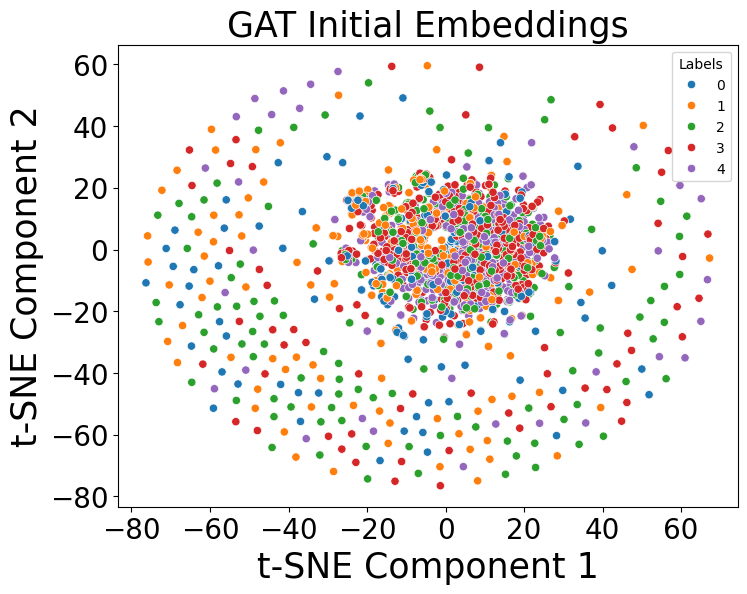

In [6]:
X=data.x
y=data.y
tsne = TSNE(n_components=2,perplexity=40, random_state=42)  # You can adjust perplexity and other parameters
X_tsne = tsne.fit_transform(X)

# Step 5: Plot the result
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='tab10')  # Separate x and y coordinates, color by labels
plt.title('GAT Initial Embeddings',fontsize = 25)
plt.xlabel('t-SNE Component 1',fontsize = 25)
plt.ylabel('t-SNE Component 2',fontsize = 25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend(title='Labels')
plt.savefig("GSAGE_input_cham.pdf",bbox_inches="tight")
plt.show()

In [7]:
import pandas as pd
Domain_Fec=pd.DataFrame(data.x.numpy())
label=pd.DataFrame(data.y.numpy(),columns =['class'])
Data=pd.concat([Domain_Fec,label], axis=1)
Data.head()

,0,1,2,3,4,5,6,7,8,9,...,2316,2317,2318,2319,2320,2321,2322,2323,2324,class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [8]:
Number_nodes=len(data.y)
fe_len=len(data.x[0])
catagories=Data['class'].to_numpy()
data_by_class = {cls: Data.loc[Data['class'] == cls].drop(['class'], axis=1) for cls in range(max(catagories) + 1)}
basis = [[max(df[i]) for i in range(len(df.columns))] for df in data_by_class.values()]
sel_basis = [[int(list(df[i].to_numpy()).count(1) >= int(len(df[i].index)*0.01)) 
              for i in range(len(df.columns))]
             for df in data_by_class.values()]
feature_names = [ii for ii in range(fe_len)]

In [9]:
def Similarity(array1, array2):
    intersection = np.sum(np.logical_and(array1, array2))
    return intersection

In [ ]:
#It takes long time
Fec=[]
for i in range(23):
    vec=[]
    f=Data.loc[i, feature_names].values.flatten().tolist()
    count=np.zeros(7)
    for j in range(1433):
        for i in range(max(catagories)+1):
            if f[j]==1 and basis[i][j]==1:
                count[i]=count[i]+1;

    for i in range(max(catagories)+1):
        vec.append(count[i])
    f.clear()
    Fec.append(vec)
print(Fec)

In [10]:

Fec=[]
for i in range(Number_nodes):
#for i in range(2):
    vec=[]
    f=Data.loc[i, feature_names].values.flatten().tolist()
    vec.append(Similarity(f,basis[0]))
    vec.append(Similarity(f,basis[1]))
    vec.append(Similarity(f,basis[2]))
    vec.append(Similarity(f,basis[3]))
    vec.append(Similarity(f,basis[4]))
    #print(f)
    f.clear()
    Fec.append(vec)
SFec=[]
for i in range(Number_nodes):
#for i in range(2):
    Svec=[]
    f=Data.loc[i, feature_names].values.flatten().tolist()
    Svec.append(Similarity(f,sel_basis[0]))
    Svec.append(Similarity(f,sel_basis[1]))
    Svec.append(Similarity(f,sel_basis[2]))
    Svec.append(Similarity(f,sel_basis[3]))
    Svec.append(Similarity(f,sel_basis[4]))
    #print(f)
    f.clear()
    SFec.append(Svec)

In [11]:
Inc_fe=torch.tensor(Fec)
sel_fe=torch.tensor(SFec)
CC_domain=torch.cat((Inc_fe, sel_fe), 1).float()
print(CC_domain)
CC_domain.type()

tensor([[ 7.,  6.,  6.,  ...,  5.,  5.,  7.],
        [10., 12., 18.,  ...,  8., 16., 15.],
        [19., 24., 39.,  ..., 19., 33., 28.],
        ...,
        [ 3.,  2.,  1.,  ...,  0.,  2.,  2.],
        [16., 20., 32.,  ..., 17., 22., 38.],
        [ 4.,  4.,  3.,  ...,  2.,  1.,  2.]])


'torch.FloatTensor'

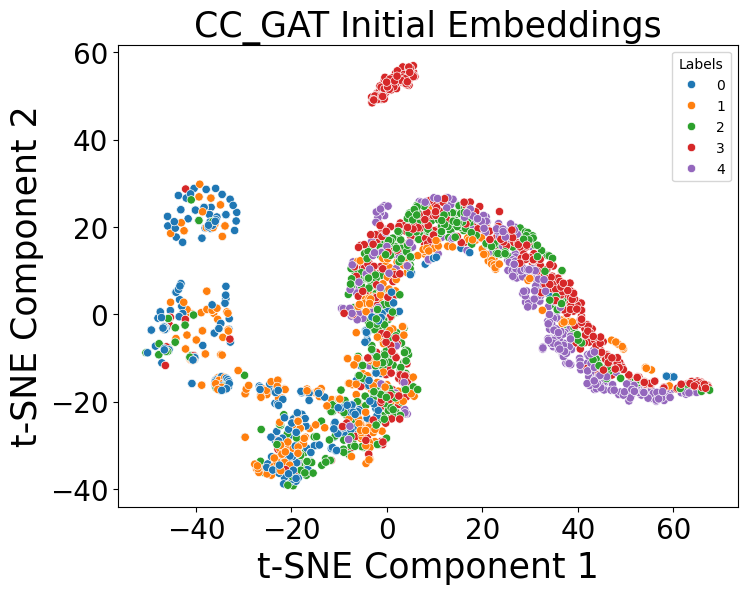

In [14]:
X=CC_domain
y=data.y
tsne = TSNE(n_components=2,perplexity=40, random_state=42)  # You can adjust perplexity and other parameters
X_tsne = tsne.fit_transform(X)

# Step 5: Plot the result
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='tab10')  # Separate x and y coordinates, color by labels
plt.title('CC_GAT Initial Embeddings',fontsize = 25)
plt.xlabel('t-SNE Component 1',fontsize = 25)
plt.ylabel('t-SNE Component 2',fontsize = 25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend(title='Labels')
plt.savefig("CC_GAT_input_cham.pdf",bbox_inches="tight")
plt.show()

# W-GAT

In [17]:
data.x=CC_domain
print(data)

Data(x=[2277, 10], y=[2277], train_mask=[2277, 10], val_mask=[2277, 10], test_mask=[2277, 10], adj_t=[2277, 2277, nnz=36101])


In [21]:
def main():
    args={'model_type': 'GCN', 'dataset': 'cora', 'num_layers': 2, 'heads': 1, 
         'batch_size': 32, 'hidden_channels': 32, 'dropout': 0.5, 'epochs': 200, 
         'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0,'runs':10, 'log_steps':1,
         'weight_decay': 5e-6, 'lr': 0.01}

    args = objectview(args)
    print(args)
    # call the dataset here with x,y,train_mask,test_mask,Val_mask, and Adj
    # To add extra feature we can simply update data.x=new fev tensor or we can add new feature
    #dataset = WebKB(root='/tmp/Texas', name='Texas',transform=T.ToSparseTensor())
    #data = dataset[0]
    data.adj_t = data.adj_t.to_symmetric()
    
    #idx_train=[data.train_mask[i][0] for i in range(len(data.y))]
    #train_idx = np.where(idx_train)[0]
    #idx_val=[data.val_mask[i][0] for i in range(len(data.y))]
    #valid_idx = np.where(idx_val)[0]
    #idx_test=[data.test_mask[i][0] for i in range(len(data.y))]
    #test_idx = np.where(idx_test)[0]
    
    model = GAT(data.num_features, args.hidden_channels,
                    dataset.num_classes, args.num_layers,
                    args.dropout)

    logger = Logger(args.runs, args)

    for run in range(args.runs):
        idx_train=[data.train_mask[i][run] for i in range(len(data.y))]
        train_idx = np.where(idx_train)[0]
        idx_val=[data.val_mask[i][run] for i in range(len(data.y))]
        valid_idx = np.where(idx_val)[0]
        idx_test=[data.test_mask[i][run] for i in range(len(data.y))]
        test_idx = np.where(idx_test)[0]
        model.reset_parameters()
        optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
        for epoch in range(1, 1 + args.epochs):
            loss = train(model, data, train_idx, optimizer)
            result = test(model, data, train_idx,valid_idx,test_idx)
            logger.add_result(run, result)

            if epoch % args.log_steps == 0:
                train_acc, valid_acc, test_acc = result
                print(f'Run: {run + 1:02d}, '
                      f'Epoch: {epoch:02d}, '
                      f'Loss: {loss:.4f}, '
                      f'Train: {100 * train_acc:.2f}%, '
                      f'Valid: {100 * valid_acc:.2f}% '
                      f'Test: {100 * test_acc:.2f}%')

        logger.print_statistics(run)
    logger.print_statistics()


if __name__ == "__main__":
    main()

Run: 01, Epoch: 01, Loss: 1.6634, Train: 22.16%, Valid: 24.42% Test: 22.37%
Run: 01, Epoch: 02, Loss: 1.5481, Train: 25.55%, Valid: 28.53% Test: 26.10%
Run: 01, Epoch: 03, Loss: 1.5169, Train: 31.87%, Valid: 31.82% Test: 29.61%
Run: 01, Epoch: 04, Loss: 1.4930, Train: 32.42%, Valid: 30.32% Test: 32.68%
Run: 01, Epoch: 05, Loss: 1.4518, Train: 32.42%, Valid: 30.18% Test: 33.11%
Run: 01, Epoch: 06, Loss: 1.4251, Train: 31.96%, Valid: 29.63% Test: 32.46%
Run: 01, Epoch: 07, Loss: 1.4234, Train: 28.11%, Valid: 25.51% Test: 28.07%
Run: 01, Epoch: 08, Loss: 1.3892, Train: 28.39%, Valid: 25.51% Test: 28.29%
Run: 01, Epoch: 09, Loss: 1.4219, Train: 28.39%, Valid: 25.38% Test: 28.29%
Run: 01, Epoch: 10, Loss: 1.4101, Train: 32.14%, Valid: 29.77% Test: 32.68%
Run: 01, Epoch: 11, Loss: 1.3834, Train: 32.23%, Valid: 29.90% Test: 33.55%
Run: 01, Epoch: 12, Loss: 1.3783, Train: 34.16%, Valid: 32.65% Test: 35.31%
Run: 01, Epoch: 13, Loss: 1.3564, Train: 34.80%, Valid: 32.65% Test: 33.99%
Run: 01, Epo

Run: 01, Epoch: 113, Loss: 1.0636, Train: 55.86%, Valid: 56.38% Test: 50.88%
Run: 01, Epoch: 114, Loss: 1.0267, Train: 57.88%, Valid: 57.34% Test: 52.85%
Run: 01, Epoch: 115, Loss: 1.0322, Train: 59.07%, Valid: 60.77% Test: 55.92%
Run: 01, Epoch: 116, Loss: 1.0174, Train: 57.60%, Valid: 60.77% Test: 56.14%
Run: 01, Epoch: 117, Loss: 1.0352, Train: 54.67%, Valid: 57.61% Test: 52.85%
Run: 01, Epoch: 118, Loss: 1.0552, Train: 59.43%, Valid: 60.63% Test: 56.80%
Run: 01, Epoch: 119, Loss: 1.0012, Train: 55.77%, Valid: 57.61% Test: 53.07%
Run: 01, Epoch: 120, Loss: 1.0040, Train: 58.06%, Valid: 58.71% Test: 54.82%
Run: 01, Epoch: 121, Loss: 1.0136, Train: 59.62%, Valid: 61.32% Test: 58.77%
Run: 01, Epoch: 122, Loss: 1.0248, Train: 57.51%, Valid: 60.49% Test: 55.26%
Run: 01, Epoch: 123, Loss: 0.9992, Train: 58.70%, Valid: 59.67% Test: 56.14%
Run: 01, Epoch: 124, Loss: 1.0005, Train: 59.98%, Valid: 60.49% Test: 56.80%
Run: 01, Epoch: 125, Loss: 0.9949, Train: 59.25%, Valid: 58.85% Test: 55.70%

Run: 02, Epoch: 21, Loss: 1.4930, Train: 30.86%, Valid: 31.14% Test: 29.39%
Run: 02, Epoch: 22, Loss: 1.4662, Train: 30.59%, Valid: 30.18% Test: 29.17%
Run: 02, Epoch: 23, Loss: 1.4874, Train: 30.22%, Valid: 29.90% Test: 28.51%
Run: 02, Epoch: 24, Loss: 1.4813, Train: 29.30%, Valid: 27.71% Test: 29.17%
Run: 02, Epoch: 25, Loss: 1.4691, Train: 30.59%, Valid: 27.85% Test: 29.39%
Run: 02, Epoch: 26, Loss: 1.4905, Train: 29.95%, Valid: 26.61% Test: 29.17%
Run: 02, Epoch: 27, Loss: 1.4856, Train: 29.85%, Valid: 27.16% Test: 28.51%
Run: 02, Epoch: 28, Loss: 1.4494, Train: 32.23%, Valid: 32.10% Test: 30.26%
Run: 02, Epoch: 29, Loss: 1.4759, Train: 33.52%, Valid: 33.74% Test: 31.58%
Run: 02, Epoch: 30, Loss: 1.4579, Train: 33.52%, Valid: 33.47% Test: 32.46%
Run: 02, Epoch: 31, Loss: 1.4446, Train: 32.69%, Valid: 34.84% Test: 30.26%
Run: 02, Epoch: 32, Loss: 1.4402, Train: 31.41%, Valid: 33.20% Test: 27.41%
Run: 02, Epoch: 33, Loss: 1.4489, Train: 31.96%, Valid: 34.16% Test: 29.82%
Run: 02, Epo

Run: 02, Epoch: 130, Loss: 1.2215, Train: 47.62%, Valid: 46.23% Test: 48.68%
Run: 02, Epoch: 131, Loss: 1.2481, Train: 46.79%, Valid: 44.31% Test: 49.78%
Run: 02, Epoch: 132, Loss: 1.2663, Train: 47.89%, Valid: 47.19% Test: 45.61%
Run: 02, Epoch: 133, Loss: 1.2389, Train: 47.25%, Valid: 46.23% Test: 46.05%
Run: 02, Epoch: 134, Loss: 1.2518, Train: 44.60%, Valid: 44.72% Test: 42.76%
Run: 02, Epoch: 135, Loss: 1.2444, Train: 45.88%, Valid: 46.64% Test: 45.61%
Run: 02, Epoch: 136, Loss: 1.2431, Train: 51.19%, Valid: 50.75% Test: 50.66%
Run: 02, Epoch: 137, Loss: 1.2386, Train: 47.07%, Valid: 45.27% Test: 46.93%
Run: 02, Epoch: 138, Loss: 1.2589, Train: 41.39%, Valid: 40.33% Test: 41.67%
Run: 02, Epoch: 139, Loss: 1.2325, Train: 45.24%, Valid: 44.03% Test: 44.30%
Run: 02, Epoch: 140, Loss: 1.2364, Train: 43.68%, Valid: 41.98% Test: 41.45%
Run: 02, Epoch: 141, Loss: 1.2437, Train: 50.09%, Valid: 48.15% Test: 49.56%
Run: 02, Epoch: 142, Loss: 1.2233, Train: 48.90%, Valid: 47.60% Test: 50.44%

Run: 03, Epoch: 36, Loss: 1.4605, Train: 33.15%, Valid: 32.78% Test: 35.09%
Run: 03, Epoch: 37, Loss: 1.4603, Train: 33.52%, Valid: 33.61% Test: 35.53%
Run: 03, Epoch: 38, Loss: 1.4232, Train: 33.42%, Valid: 34.02% Test: 35.09%
Run: 03, Epoch: 39, Loss: 1.4415, Train: 33.15%, Valid: 34.29% Test: 36.18%
Run: 03, Epoch: 40, Loss: 1.4516, Train: 33.15%, Valid: 33.47% Test: 35.09%
Run: 03, Epoch: 41, Loss: 1.4556, Train: 36.26%, Valid: 36.63% Test: 36.62%
Run: 03, Epoch: 42, Loss: 1.4516, Train: 32.69%, Valid: 34.16% Test: 33.77%
Run: 03, Epoch: 43, Loss: 1.4515, Train: 31.50%, Valid: 32.51% Test: 33.99%
Run: 03, Epoch: 44, Loss: 1.4433, Train: 30.59%, Valid: 30.86% Test: 32.02%
Run: 03, Epoch: 45, Loss: 1.4099, Train: 31.04%, Valid: 30.45% Test: 31.80%
Run: 03, Epoch: 46, Loss: 1.4149, Train: 31.68%, Valid: 31.69% Test: 31.14%
Run: 03, Epoch: 47, Loss: 1.4357, Train: 29.12%, Valid: 29.22% Test: 27.19%
Run: 03, Epoch: 48, Loss: 1.4402, Train: 28.11%, Valid: 30.86% Test: 27.85%
Run: 03, Epo

Run: 03, Epoch: 144, Loss: 1.3380, Train: 38.92%, Valid: 40.47% Test: 37.50%
Run: 03, Epoch: 145, Loss: 1.3118, Train: 38.37%, Valid: 40.33% Test: 38.38%
Run: 03, Epoch: 146, Loss: 1.3415, Train: 40.75%, Valid: 41.29% Test: 39.91%
Run: 03, Epoch: 147, Loss: 1.3352, Train: 38.92%, Valid: 38.96% Test: 36.62%
Run: 03, Epoch: 148, Loss: 1.2952, Train: 39.56%, Valid: 37.31% Test: 36.62%
Run: 03, Epoch: 149, Loss: 1.3091, Train: 39.93%, Valid: 37.31% Test: 37.28%
Run: 03, Epoch: 150, Loss: 1.2967, Train: 38.00%, Valid: 36.49% Test: 34.87%
Run: 03, Epoch: 151, Loss: 1.2831, Train: 39.84%, Valid: 38.55% Test: 35.31%
Run: 03, Epoch: 152, Loss: 1.2908, Train: 47.25%, Valid: 44.17% Test: 45.83%
Run: 03, Epoch: 153, Loss: 1.2997, Train: 43.86%, Valid: 40.33% Test: 43.64%
Run: 03, Epoch: 154, Loss: 1.3122, Train: 44.05%, Valid: 40.74% Test: 43.20%
Run: 03, Epoch: 155, Loss: 1.2883, Train: 43.04%, Valid: 40.05% Test: 42.11%
Run: 03, Epoch: 156, Loss: 1.2743, Train: 41.21%, Valid: 38.55% Test: 42.32%

Run: 04, Epoch: 53, Loss: 1.3047, Train: 42.12%, Valid: 40.74% Test: 37.72%
Run: 04, Epoch: 54, Loss: 1.3057, Train: 40.02%, Valid: 38.55% Test: 38.38%
Run: 04, Epoch: 55, Loss: 1.2946, Train: 40.93%, Valid: 38.00% Test: 35.96%
Run: 04, Epoch: 56, Loss: 1.3188, Train: 44.23%, Valid: 43.21% Test: 38.82%
Run: 04, Epoch: 57, Loss: 1.3075, Train: 43.59%, Valid: 40.60% Test: 39.25%
Run: 04, Epoch: 58, Loss: 1.3029, Train: 42.95%, Valid: 40.05% Test: 38.60%
Run: 04, Epoch: 59, Loss: 1.2994, Train: 43.13%, Valid: 39.92% Test: 39.25%
Run: 04, Epoch: 60, Loss: 1.2887, Train: 45.42%, Valid: 40.33% Test: 42.54%
Run: 04, Epoch: 61, Loss: 1.2945, Train: 45.60%, Valid: 40.47% Test: 41.01%
Run: 04, Epoch: 62, Loss: 1.2872, Train: 46.25%, Valid: 43.62% Test: 41.01%
Run: 04, Epoch: 63, Loss: 1.2996, Train: 45.42%, Valid: 41.56% Test: 41.45%
Run: 04, Epoch: 64, Loss: 1.2925, Train: 44.60%, Valid: 40.05% Test: 42.76%
Run: 04, Epoch: 65, Loss: 1.2810, Train: 44.41%, Valid: 39.51% Test: 40.35%
Run: 04, Epo

Run: 04, Epoch: 162, Loss: 1.2259, Train: 44.87%, Valid: 39.09% Test: 41.89%
Run: 04, Epoch: 163, Loss: 1.2431, Train: 44.23%, Valid: 40.74% Test: 40.79%
Run: 04, Epoch: 164, Loss: 1.2124, Train: 42.86%, Valid: 39.23% Test: 39.91%
Run: 04, Epoch: 165, Loss: 1.2178, Train: 42.31%, Valid: 39.78% Test: 42.11%
Run: 04, Epoch: 166, Loss: 1.2319, Train: 42.40%, Valid: 40.60% Test: 43.64%
Run: 04, Epoch: 167, Loss: 1.2232, Train: 43.86%, Valid: 40.88% Test: 41.89%
Run: 04, Epoch: 168, Loss: 1.2231, Train: 44.78%, Valid: 42.11% Test: 41.89%
Run: 04, Epoch: 169, Loss: 1.2197, Train: 44.05%, Valid: 39.92% Test: 40.57%
Run: 04, Epoch: 170, Loss: 1.2094, Train: 42.49%, Valid: 37.86% Test: 39.91%
Run: 04, Epoch: 171, Loss: 1.2185, Train: 44.05%, Valid: 39.64% Test: 41.67%
Run: 04, Epoch: 172, Loss: 1.2175, Train: 48.90%, Valid: 45.27% Test: 46.05%
Run: 04, Epoch: 173, Loss: 1.2152, Train: 49.54%, Valid: 45.68% Test: 46.05%
Run: 04, Epoch: 174, Loss: 1.2269, Train: 47.89%, Valid: 45.68% Test: 44.96%

Run: 05, Epoch: 74, Loss: 1.4166, Train: 34.43%, Valid: 31.55% Test: 30.70%
Run: 05, Epoch: 75, Loss: 1.4131, Train: 34.43%, Valid: 31.14% Test: 31.14%
Run: 05, Epoch: 76, Loss: 1.4065, Train: 34.25%, Valid: 31.82% Test: 30.26%
Run: 05, Epoch: 77, Loss: 1.4175, Train: 35.26%, Valid: 32.24% Test: 30.70%
Run: 05, Epoch: 78, Loss: 1.4168, Train: 35.62%, Valid: 32.10% Test: 31.36%
Run: 05, Epoch: 79, Loss: 1.4149, Train: 34.71%, Valid: 31.28% Test: 31.14%
Run: 05, Epoch: 80, Loss: 1.4125, Train: 33.70%, Valid: 29.63% Test: 28.07%
Run: 05, Epoch: 81, Loss: 1.4179, Train: 32.51%, Valid: 29.36% Test: 26.97%
Run: 05, Epoch: 82, Loss: 1.4141, Train: 33.52%, Valid: 28.40% Test: 26.75%
Run: 05, Epoch: 83, Loss: 1.3999, Train: 33.61%, Valid: 28.40% Test: 28.51%
Run: 05, Epoch: 84, Loss: 1.4250, Train: 35.44%, Valid: 32.10% Test: 32.46%
Run: 05, Epoch: 85, Loss: 1.4093, Train: 35.99%, Valid: 33.20% Test: 32.46%
Run: 05, Epoch: 86, Loss: 1.4022, Train: 37.18%, Valid: 34.43% Test: 33.77%
Run: 05, Epo

Run: 05, Epoch: 182, Loss: 1.3383, Train: 43.04%, Valid: 41.84% Test: 44.08%
Run: 05, Epoch: 183, Loss: 1.3608, Train: 43.77%, Valid: 41.84% Test: 43.86%
Run: 05, Epoch: 184, Loss: 1.3355, Train: 44.96%, Valid: 42.11% Test: 44.30%
Run: 05, Epoch: 185, Loss: 1.3284, Train: 43.04%, Valid: 39.51% Test: 41.67%
Run: 05, Epoch: 186, Loss: 1.3485, Train: 43.59%, Valid: 41.02% Test: 42.11%
Run: 05, Epoch: 187, Loss: 1.3448, Train: 43.13%, Valid: 40.05% Test: 41.89%
Run: 05, Epoch: 188, Loss: 1.3543, Train: 42.49%, Valid: 40.19% Test: 41.01%
Run: 05, Epoch: 189, Loss: 1.3346, Train: 42.58%, Valid: 40.33% Test: 40.35%
Run: 05, Epoch: 190, Loss: 1.3381, Train: 42.03%, Valid: 38.68% Test: 40.13%
Run: 05, Epoch: 191, Loss: 1.3244, Train: 40.84%, Valid: 38.96% Test: 38.82%
Run: 05, Epoch: 192, Loss: 1.3263, Train: 41.12%, Valid: 38.41% Test: 39.69%
Run: 05, Epoch: 193, Loss: 1.3245, Train: 41.94%, Valid: 39.92% Test: 41.23%
Run: 05, Epoch: 194, Loss: 1.3264, Train: 41.67%, Valid: 38.96% Test: 39.69%

Run: 06, Epoch: 91, Loss: 1.0645, Train: 54.40%, Valid: 54.73% Test: 55.26%
Run: 06, Epoch: 92, Loss: 1.1063, Train: 56.14%, Valid: 56.24% Test: 57.02%
Run: 06, Epoch: 93, Loss: 1.0883, Train: 56.14%, Valid: 54.46% Test: 53.07%
Run: 06, Epoch: 94, Loss: 1.1155, Train: 56.78%, Valid: 54.60% Test: 54.39%
Run: 06, Epoch: 95, Loss: 1.0765, Train: 54.67%, Valid: 51.30% Test: 53.07%
Run: 06, Epoch: 96, Loss: 1.1466, Train: 55.31%, Valid: 53.22% Test: 53.95%
Run: 06, Epoch: 97, Loss: 1.0659, Train: 56.14%, Valid: 55.83% Test: 54.39%
Run: 06, Epoch: 98, Loss: 1.0785, Train: 57.88%, Valid: 57.06% Test: 58.11%
Run: 06, Epoch: 99, Loss: 1.0814, Train: 55.95%, Valid: 55.83% Test: 56.80%
Run: 06, Epoch: 100, Loss: 1.0888, Train: 58.33%, Valid: 56.65% Test: 58.99%
Run: 06, Epoch: 101, Loss: 1.0678, Train: 56.14%, Valid: 55.42% Test: 54.39%
Run: 06, Epoch: 102, Loss: 1.1022, Train: 53.85%, Valid: 52.67% Test: 55.26%
Run: 06, Epoch: 103, Loss: 1.0953, Train: 54.95%, Valid: 52.95% Test: 54.61%
Run: 06,

Run: 07, Epoch: 01, Loss: 1.9948, Train: 20.42%, Valid: 17.42% Test: 22.59%
Run: 07, Epoch: 02, Loss: 1.8864, Train: 20.42%, Valid: 17.42% Test: 22.59%
Run: 07, Epoch: 03, Loss: 1.7846, Train: 20.42%, Valid: 17.56% Test: 23.03%
Run: 07, Epoch: 04, Loss: 1.7706, Train: 17.95%, Valid: 15.64% Test: 20.18%
Run: 07, Epoch: 05, Loss: 1.6138, Train: 18.68%, Valid: 15.78% Test: 18.20%
Run: 07, Epoch: 06, Loss: 1.5794, Train: 21.70%, Valid: 20.99% Test: 19.96%
Run: 07, Epoch: 07, Loss: 1.5265, Train: 25.00%, Valid: 25.65% Test: 19.52%
Run: 07, Epoch: 08, Loss: 1.5224, Train: 24.08%, Valid: 24.28% Test: 20.83%
Run: 07, Epoch: 09, Loss: 1.5469, Train: 24.36%, Valid: 24.42% Test: 19.96%
Run: 07, Epoch: 10, Loss: 1.5436, Train: 24.73%, Valid: 24.28% Test: 19.52%
Run: 07, Epoch: 11, Loss: 1.4896, Train: 25.37%, Valid: 24.83% Test: 19.96%
Run: 07, Epoch: 12, Loss: 1.5326, Train: 24.82%, Valid: 23.73% Test: 20.18%
Run: 07, Epoch: 13, Loss: 1.4845, Train: 25.00%, Valid: 22.63% Test: 19.52%
Run: 07, Epo

Run: 07, Epoch: 114, Loss: 1.2735, Train: 43.59%, Valid: 40.19% Test: 40.13%
Run: 07, Epoch: 115, Loss: 1.2814, Train: 43.86%, Valid: 43.07% Test: 40.79%
Run: 07, Epoch: 116, Loss: 1.2916, Train: 41.67%, Valid: 42.11% Test: 37.28%
Run: 07, Epoch: 117, Loss: 1.3104, Train: 42.12%, Valid: 40.47% Test: 38.82%
Run: 07, Epoch: 118, Loss: 1.2646, Train: 43.13%, Valid: 40.60% Test: 40.57%
Run: 07, Epoch: 119, Loss: 1.2562, Train: 41.67%, Valid: 38.82% Test: 38.60%
Run: 07, Epoch: 120, Loss: 1.2604, Train: 40.20%, Valid: 35.12% Test: 37.72%
Run: 07, Epoch: 121, Loss: 1.2716, Train: 43.41%, Valid: 38.27% Test: 39.25%
Run: 07, Epoch: 122, Loss: 1.2675, Train: 43.04%, Valid: 38.55% Test: 39.91%
Run: 07, Epoch: 123, Loss: 1.3143, Train: 42.95%, Valid: 40.47% Test: 39.04%
Run: 07, Epoch: 124, Loss: 1.3639, Train: 42.49%, Valid: 41.02% Test: 36.40%
Run: 07, Epoch: 125, Loss: 1.2615, Train: 41.58%, Valid: 39.64% Test: 35.31%
Run: 07, Epoch: 126, Loss: 1.2500, Train: 44.60%, Valid: 40.74% Test: 39.04%

Run: 08, Epoch: 25, Loss: 1.4475, Train: 34.25%, Valid: 33.88% Test: 34.65%
Run: 08, Epoch: 26, Loss: 1.4677, Train: 34.16%, Valid: 33.33% Test: 34.43%
Run: 08, Epoch: 27, Loss: 1.4549, Train: 34.80%, Valid: 34.16% Test: 33.99%
Run: 08, Epoch: 28, Loss: 1.4939, Train: 32.69%, Valid: 33.20% Test: 31.80%
Run: 08, Epoch: 29, Loss: 1.4377, Train: 32.42%, Valid: 33.47% Test: 30.48%
Run: 08, Epoch: 30, Loss: 1.4494, Train: 32.33%, Valid: 33.33% Test: 30.26%
Run: 08, Epoch: 31, Loss: 1.4357, Train: 33.88%, Valid: 35.39% Test: 32.68%
Run: 08, Epoch: 32, Loss: 1.4422, Train: 33.88%, Valid: 35.53% Test: 31.80%
Run: 08, Epoch: 33, Loss: 1.4070, Train: 34.07%, Valid: 35.39% Test: 32.24%
Run: 08, Epoch: 34, Loss: 1.4333, Train: 33.42%, Valid: 35.80% Test: 32.24%
Run: 08, Epoch: 35, Loss: 1.4065, Train: 33.33%, Valid: 36.08% Test: 33.33%
Run: 08, Epoch: 36, Loss: 1.3957, Train: 33.33%, Valid: 35.53% Test: 32.68%
Run: 08, Epoch: 37, Loss: 1.4161, Train: 33.15%, Valid: 34.71% Test: 31.80%
Run: 08, Epo

Run: 08, Epoch: 133, Loss: 1.0897, Train: 55.22%, Valid: 50.62% Test: 51.75%
Run: 08, Epoch: 134, Loss: 1.1034, Train: 55.86%, Valid: 49.79% Test: 51.97%
Run: 08, Epoch: 135, Loss: 1.0848, Train: 56.68%, Valid: 52.26% Test: 52.19%
Run: 08, Epoch: 136, Loss: 1.1154, Train: 55.31%, Valid: 50.07% Test: 51.10%
Run: 08, Epoch: 137, Loss: 1.0927, Train: 54.85%, Valid: 49.79% Test: 50.88%
Run: 08, Epoch: 138, Loss: 1.1143, Train: 54.40%, Valid: 50.21% Test: 47.81%
Run: 08, Epoch: 139, Loss: 1.0987, Train: 53.66%, Valid: 49.93% Test: 46.93%
Run: 08, Epoch: 140, Loss: 1.1065, Train: 51.01%, Valid: 46.91% Test: 42.11%
Run: 08, Epoch: 141, Loss: 1.1174, Train: 48.99%, Valid: 46.36% Test: 40.13%
Run: 08, Epoch: 142, Loss: 1.0916, Train: 47.34%, Valid: 45.82% Test: 41.01%
Run: 08, Epoch: 143, Loss: 1.1120, Train: 44.51%, Valid: 43.62% Test: 41.89%
Run: 08, Epoch: 144, Loss: 1.1251, Train: 43.13%, Valid: 42.52% Test: 40.79%
Run: 08, Epoch: 145, Loss: 1.0891, Train: 48.53%, Valid: 46.09% Test: 44.30%

Run: 09, Epoch: 39, Loss: 1.2368, Train: 47.25%, Valid: 47.74% Test: 46.27%
Run: 09, Epoch: 40, Loss: 1.2059, Train: 46.25%, Valid: 45.68% Test: 46.05%
Run: 09, Epoch: 41, Loss: 1.2072, Train: 47.16%, Valid: 47.19% Test: 46.71%
Run: 09, Epoch: 42, Loss: 1.1873, Train: 47.99%, Valid: 46.91% Test: 47.81%
Run: 09, Epoch: 43, Loss: 1.1892, Train: 47.80%, Valid: 47.60% Test: 45.39%
Run: 09, Epoch: 44, Loss: 1.1984, Train: 47.07%, Valid: 47.05% Test: 44.52%
Run: 09, Epoch: 45, Loss: 1.2454, Train: 48.26%, Valid: 46.36% Test: 43.20%
Run: 09, Epoch: 46, Loss: 1.1976, Train: 47.44%, Valid: 44.17% Test: 41.45%
Run: 09, Epoch: 47, Loss: 1.1779, Train: 49.08%, Valid: 45.40% Test: 43.86%
Run: 09, Epoch: 48, Loss: 1.2010, Train: 48.26%, Valid: 46.64% Test: 44.30%
Run: 09, Epoch: 49, Loss: 1.1947, Train: 49.27%, Valid: 49.11% Test: 46.49%
Run: 09, Epoch: 50, Loss: 1.1331, Train: 50.18%, Valid: 49.93% Test: 48.90%
Run: 09, Epoch: 51, Loss: 1.1715, Train: 51.56%, Valid: 51.30% Test: 50.00%
Run: 09, Epo

Run: 09, Epoch: 149, Loss: 1.0479, Train: 54.40%, Valid: 53.50% Test: 53.95%
Run: 09, Epoch: 150, Loss: 1.0517, Train: 55.95%, Valid: 55.01% Test: 56.36%
Run: 09, Epoch: 151, Loss: 1.0257, Train: 56.87%, Valid: 56.10% Test: 57.24%
Run: 09, Epoch: 152, Loss: 1.0349, Train: 55.31%, Valid: 55.42% Test: 55.70%
Run: 09, Epoch: 153, Loss: 1.0565, Train: 57.05%, Valid: 56.79% Test: 57.89%
Run: 09, Epoch: 154, Loss: 1.0556, Train: 56.96%, Valid: 55.01% Test: 56.14%
Run: 09, Epoch: 155, Loss: 1.0349, Train: 57.14%, Valid: 56.38% Test: 56.58%
Run: 09, Epoch: 156, Loss: 1.0412, Train: 56.50%, Valid: 55.28% Test: 56.36%
Run: 09, Epoch: 157, Loss: 1.0037, Train: 54.49%, Valid: 53.77% Test: 53.95%
Run: 09, Epoch: 158, Loss: 1.0439, Train: 58.15%, Valid: 56.52% Test: 59.21%
Run: 09, Epoch: 159, Loss: 1.0117, Train: 57.14%, Valid: 56.52% Test: 57.46%
Run: 09, Epoch: 160, Loss: 1.0153, Train: 58.70%, Valid: 56.93% Test: 59.43%
Run: 09, Epoch: 161, Loss: 1.0053, Train: 58.61%, Valid: 56.93% Test: 59.65%

Run: 10, Epoch: 55, Loss: 1.0975, Train: 51.19%, Valid: 50.89% Test: 50.22%
Run: 10, Epoch: 56, Loss: 1.0850, Train: 51.74%, Valid: 50.48% Test: 48.68%
Run: 10, Epoch: 57, Loss: 1.1727, Train: 52.47%, Valid: 49.93% Test: 50.88%
Run: 10, Epoch: 58, Loss: 1.1292, Train: 51.83%, Valid: 50.48% Test: 51.10%
Run: 10, Epoch: 59, Loss: 1.1047, Train: 51.10%, Valid: 50.48% Test: 51.10%
Run: 10, Epoch: 60, Loss: 1.0884, Train: 52.93%, Valid: 50.62% Test: 51.10%
Run: 10, Epoch: 61, Loss: 1.0993, Train: 52.47%, Valid: 50.34% Test: 52.41%
Run: 10, Epoch: 62, Loss: 1.0913, Train: 52.11%, Valid: 49.52% Test: 51.75%
Run: 10, Epoch: 63, Loss: 1.1311, Train: 49.27%, Valid: 48.42% Test: 48.90%
Run: 10, Epoch: 64, Loss: 1.0894, Train: 54.85%, Valid: 54.46% Test: 52.41%
Run: 10, Epoch: 65, Loss: 1.0979, Train: 54.95%, Valid: 55.69% Test: 55.04%
Run: 10, Epoch: 66, Loss: 1.1193, Train: 56.96%, Valid: 55.56% Test: 56.36%
Run: 10, Epoch: 67, Loss: 1.0851, Train: 54.40%, Valid: 51.44% Test: 54.17%
Run: 10, Epo

Run: 10, Epoch: 167, Loss: 0.9707, Train: 59.43%, Valid: 57.34% Test: 58.11%
Run: 10, Epoch: 168, Loss: 0.9916, Train: 59.98%, Valid: 58.71% Test: 58.99%
Run: 10, Epoch: 169, Loss: 0.9593, Train: 57.69%, Valid: 55.42% Test: 57.68%
Run: 10, Epoch: 170, Loss: 0.9874, Train: 57.42%, Valid: 55.83% Test: 57.68%
Run: 10, Epoch: 171, Loss: 0.9980, Train: 61.36%, Valid: 58.02% Test: 62.50%
Run: 10, Epoch: 172, Loss: 0.9736, Train: 60.07%, Valid: 55.97% Test: 59.43%
Run: 10, Epoch: 173, Loss: 0.9784, Train: 58.06%, Valid: 53.50% Test: 56.36%
Run: 10, Epoch: 174, Loss: 0.9604, Train: 58.33%, Valid: 53.64% Test: 55.48%
Run: 10, Epoch: 175, Loss: 1.0182, Train: 57.42%, Valid: 53.36% Test: 55.26%
Run: 10, Epoch: 176, Loss: 0.9829, Train: 57.97%, Valid: 53.36% Test: 55.04%
Run: 10, Epoch: 177, Loss: 0.9572, Train: 57.60%, Valid: 52.81% Test: 54.39%
Run: 10, Epoch: 178, Loss: 0.9351, Train: 57.51%, Valid: 53.50% Test: 56.36%
Run: 10, Epoch: 179, Loss: 0.9546, Train: 62.82%, Valid: 56.93% Test: 61.62%

In [16]:
dataset = WikipediaNetwork(root='/tmp/chameleon', name='chameleon',transform=T.ToSparseTensor())
data = dataset[0]
print(data)

Data(x=[2277, 2325], y=[2277], train_mask=[2277, 10], val_mask=[2277, 10], test_mask=[2277, 10], adj_t=[2277, 2277, nnz=36101])


In [17]:
import pandas as pd
Domain_Fec=pd.DataFrame(data.x.numpy())
label=pd.DataFrame(data.y.numpy(),columns =['class'])
Data=pd.concat([Domain_Fec,label], axis=1)
Data.head()

,0,1,2,3,4,5,6,7,8,9,...,2316,2317,2318,2319,2320,2321,2322,2323,2324,class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [18]:
Number_nodes=len(data.y)
fe_len=len(data.x[0])
catagories=Data['class'].to_numpy()
data_by_class = {cls: Data.loc[Data['class'] == cls].drop(['class'], axis=1) for cls in range(max(catagories) + 1)}
feature_names = [ii for ii in range(fe_len)]

# Topological Embeding 

In [ ]:
dataset = WikipediaNetwork(root='/tmp/chameleon', name='chameleon')
data = dataset[0]
print(data)

In [ ]:
print(data.edge_index.numpy())

In [ ]:
Edge_idx=data.edge_index.numpy()
Node=range(Number_nodes)
Edgelist=[]
for i in range(len(Edge_idx[1])):
    Edgelist.append((Edge_idx[0][i],Edge_idx[1][i]))
#print(Edgelist)

In [ ]:
# a "plain" graph is undirected
#G = nx.DiGraph()
G = nx.Graph()

# give each a node a 'name', which is a letter in this case.
#G.add_node('a')

# the add_nodes_from method allows adding nodes from a sequence, in this case a list
#nodes_to_add = ['b', 'c', 'd']
G.add_nodes_from(Node)

# add edge from 'a' to 'b'
# since this graph is undirected, the order doesn't matter here
#G.add_edge('a', 'b')

# just like add_nodes_from, we can add edges from a sequence
# edges should be specified as 2-tuples
#edges_to_add = [('a', 'c'), ('b', 'c'), ('c', 'd')]
G.add_edges_from(Edgelist)


In [ ]:
print(G.number_of_edges())

In [ ]:
def Topological_Feature_subLevel(adj,filtration_fun, Filtration):
        betti_0=[]
        betti_1=[]
        for p in range(len(Filtration)):
            n_active = np.where(np.array(filtration_fun) <= Filtration[p])[0].tolist()
            Active_node=np.unique(n_active)
            if (len(Active_node)==0):
                betti_0.append(0)
                betti_1.append(0)
            else:
                b=adj[Active_node,:][:,Active_node]
                my_flag=pyflagser.flagser_unweighted(b, min_dimension=0, max_dimension=2, directed=False, coeff=2, approximation=None)
                x = my_flag["betti"]
                betti_0.append(x[0])
                betti_1.append(x[1])
            n_active.clear()
        return betti_0,betti_1

In [ ]:
def Degree_list(Graph):
    degree_list = [Graph.degree(node) for node in Graph.nodes]
    return np.array(degree_list)

In [ ]:
degree_list=Degree_list(G)
unique_list=np.unique(degree_list)
for d in unique_list:
    count=0
    for i in range(len(degree_list)):
        if degree_list[i]==d:
            count=count+1
    print(int(d)," | ",count,'\n')

In [ ]:
import pyflagser
Node_fil=[1,2,3,4,5,6,7,8,9,10,12,15,20,25,30,50,100,200,400]
topo_betti_0=[]
topo_betti_1=[]
Node_Edge=[]
for i in range(Number_nodes):
    print("\rProcessing file {} ({}%)".format(i, 100*i//(Number_nodes-1)), end='', flush=True)
    subgraph=ego_graph(G, i, radius=2, center=True, undirected=True, distance=None)
    filt=Degree_list(subgraph)
    A_sub = nx.to_numpy_array(subgraph)# adjacency matrix of subgraph
    fe=Topological_Feature_subLevel(A_sub,filt,Node_fil)
    topo_betti_0.append(fe[0])
    topo_betti_1.append(fe[1])
    Node_Edge.append([subgraph.number_of_nodes(),subgraph.number_of_edges()])
    #topo_with_NE.app

In [22]:
data = pd.read_csv('Feature_Cham.csv')
data.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,9.1,10.1,11.1,12.1,13.1,14.1,15.1,16.1,17.1,18.1
0,0,0,5,5,13,14,14,14,8,8,...,3,5,13,13,10,10,10,10,10,10
1,1,4,13,20,25,27,24,25,27,26,...,0,0,3,13,40,56,25,3,3,3
2,2,3,4,11,12,17,18,26,26,30,...,0,4,6,13,23,38,170,308,44,13
3,3,7,7,7,7,7,7,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,4,33,89,109,134,201,266,309,324,328,...,14,15,27,53,105,185,1191,1169,617,617


In [23]:
Data1=data.drop(['Unnamed: 0'], axis=1)
Data1.head()

,0,1,2,3,4,5,6,7,8,9,...,9.1,10.1,11.1,12.1,13.1,14.1,15.1,16.1,17.1,18.1
0,0,5,5,13,14,14,14,8,8,8,...,3,5,13,13,10,10,10,10,10,10
1,4,13,20,25,27,24,25,27,26,27,...,0,0,3,13,40,56,25,3,3,3
2,3,4,11,12,17,18,26,26,30,31,...,0,4,6,13,23,38,170,308,44,13
3,7,7,7,7,7,7,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,33,89,109,134,201,266,309,324,328,321,...,14,15,27,53,105,185,1191,1169,617,617


In [24]:
Topo_fe=torch.tensor(Data1.values).float()

In [25]:
dataset = WikipediaNetwork(root='/tmp/chameleon', name='chameleon',transform=T.ToSparseTensor())
data = dataset[0]
print(data)

Data(x=[2277, 2325], y=[2277], train_mask=[2277, 10], val_mask=[2277, 10], test_mask=[2277, 10], adj_t=[2277, 2277, nnz=36101])


In [26]:
data.x=CC_domain
data.topo=Topo_fe
print(data)

Data(x=[2277, 10], y=[2277], train_mask=[2277, 10], val_mask=[2277, 10], test_mask=[2277, 10], adj_t=[2277, 2277, nnz=36101], topo=[2277, 38])


# TOPO_W_GAT

In [27]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(GAT, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(GATConv(in_channels, hidden_channels))
        self.bns = torch.nn.ModuleList()
        self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(GATConv(hidden_channels, hidden_channels))
            self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        self.convs.append(GATConv(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, adj_t):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, adj_t)
            x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, adj_t)
        return x
        #return x.log_softmax(dim=-1)

class MLP(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(MLP, self).__init__()

        self.lins = torch.nn.ModuleList()
        self.lins.append(torch.nn.Linear(in_channels, hidden_channels))
        self.bns = torch.nn.ModuleList()
        self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        for _ in range(num_layers - 2):
            self.lins.append(torch.nn.Linear(hidden_channels, hidden_channels))
            self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        self.lins.append(torch.nn.Linear(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters_mlp(self):
        for lin in self.lins:
            lin.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x):
        for i, lin in enumerate(self.lins[:-1]):
            x = lin(x)
            x = self.bns[i](x)
            #x = F.relu(x)
            x=F.sigmoid(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lins[-1](x)
        #return torch.log_softmax(x, dim=-1)
        return x
    
class MLP2(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(MLP2, self).__init__()

        self.lins = torch.nn.ModuleList()
        self.lins.append(torch.nn.Linear(in_channels, hidden_channels))
        self.bns = torch.nn.ModuleList()
        self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        for _ in range(num_layers - 2):
            self.lins.append(torch.nn.Linear(hidden_channels, hidden_channels))
            self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        self.lins.append(torch.nn.Linear(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters_mlp2(self):
        for lin in self.lins:
            lin.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x):
        for i, lin in enumerate(self.lins[:-1]):
            x = lin(x)
            x = self.bns[i](x)
            #x = F.relu(x)
            x=F.sigmoid(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lins[-1](x)
        return torch.log_softmax(x, dim=-1)
    

def train(model,mlp_model,mlp_2,data, train_idx, optimizer,optimizer_mlp,optimizer_mlp2):
    model.train()
    mlp_model.train()
    mlp_2.train()
    optimizer.zero_grad()
    optimizer_mlp.zero_grad()
    optimizer_mlp2.zero_grad()
    gcn_embedding = model(data.x, data.adj_t)[train_idx]
    #print(gcn_embedding)
    mlp_embedding = mlp_model(data.topo[train_idx])
    #print(mlp_embedding)
    combined_embedding = torch.cat((gcn_embedding, mlp_embedding), dim=1)
    #print(combined_embedding)
    mlp_emb = mlp_2(combined_embedding)
    #print(mlp_emb)
    loss = F.nll_loss(mlp_emb, data.y.squeeze()[train_idx])
    #loss = F.nll_loss(combined_embedding, data.y.squeeze()[train_idx])
    loss.backward()
    optimizer_mlp2.step()
    optimizer.step()
    optimizer_mlp.step()
    

    return loss.item()


def ACC(Prediction, Label):
    correct = Prediction.view(-1).eq(Label).sum().item()
    total=len(Label)
    return correct / total



@torch.no_grad()
def test(model,mlp_model,mlp_2,data, train_idx,valid_idx,test_idx):
    model.eval()
    mlp_model.eval()
    mlp_2.eval()

    gcn_out = model(data.x, data.adj_t)
    #print(gcn_out[0])
    mlp_out=mlp_model(data.topo)
    #print(mlp_out)
    #out=torch.cat((gcn_out,mlp_out),dim=1)
    Com=torch.cat((gcn_out,mlp_out),dim=1)
    out=mlp_2(Com)
    y_pred = out.argmax(dim=-1, keepdim=True)
    #print(y_pred[0])
    y_pred=y_pred.view(-1)
    train_acc=ACC(data.y[train_idx],y_pred[train_idx])
    valid_acc=ACC(data.y[valid_idx],y_pred[valid_idx])
    test_acc =ACC(data.y[test_idx],y_pred[test_idx])
    return train_acc, valid_acc, test_acc

class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

In [28]:
def main():
    args={'model_type': 'GCN', 'dataset': 'cora', 'num_layers': 2, 'heads': 1, 
         'batch_size': 32, 'hidden_channels': 32, 'dropout': 0.5, 'epochs': 100, 
         'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0,'runs':10, 'log_steps':1,
         'weight_decay': 5e-6, 'lr': 0.01,'hidden_channels_mlp': 20,'dropout_mlp': 0.5,'num_layers_mlp': 3}

    args = objectview(args)
    print(args)
    # call the dataset here with x,y,train_mask,test_mask,Val_mask, and Adj
    # To add extra feature we can simply update data.x=new fev tensor or we can add new feature
    #dataset = Planetoid(root='/tmp/cora', name='Cora',transform=T.ToSparseTensor())
    #data = dataset[0]
    X = data.topo
    y_true = data.y
    data.adj_t = data.adj_t.to_symmetric()
    
    model = GAT(data.num_features, args.hidden_channels,10, args.num_layers,args.dropout)
    mlp_model = MLP(X.size(-1), args.hidden_channels_mlp, 5,args.num_layers_mlp, args.dropout_mlp)
    #print(mlp_model.parameters())
    mlp_2 = MLP2(15, 100, dataset.num_classes,3, 0.0)

    logger = Logger(args.runs, args)

    for run in range(args.runs):
        idx_train=[data.train_mask[i][run] for i in range(len(data.y))]
        train_idx = np.where(idx_train)[0]
        idx_val=[data.val_mask[i][run] for i in range(len(data.y))]
        valid_idx = np.where(idx_val)[0]
        idx_test=[data.test_mask[i][run] for i in range(len(data.y))]
        test_idx = np.where(idx_test)[0]
        
        model.reset_parameters()
        mlp_model.reset_parameters_mlp()
        mlp_2.reset_parameters_mlp2()
        optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
        optimizer_mlp=torch.optim.Adam(mlp_model.parameters(), lr=0.01)
        optimizer_mlp2=torch.optim.Adam(mlp_2.parameters(), lr=0.01)
        for epoch in range(1, 1 + args.epochs):
            loss = train(model,mlp_model,mlp_2,data, train_idx, optimizer,optimizer_mlp,optimizer_mlp2)
            result = test(model,mlp_model,mlp_2,data, train_idx,valid_idx,test_idx)
            logger.add_result(run, result)

            if epoch % args.log_steps == 0:
                train_acc, valid_acc, test_acc = result
                print(f'Run: {run + 1:02d}, '
                      f'Epoch: {epoch:02d}, '
                      f'Loss: {loss:.4f}, '
                      f'Train: {100 * train_acc:.2f}%, '
                      f'Valid: {100 * valid_acc:.2f}% '
                      f'Test: {100 * test_acc:.2f}%')

        logger.print_statistics(run)
    logger.print_statistics()


if __name__ == "__main__":
    main()

Run: 01, Epoch: 01, Loss: 1.6077, Train: 22.07%, Valid: 24.42% Test: 22.37%
Run: 01, Epoch: 02, Loss: 1.5465, Train: 22.07%, Valid: 24.42% Test: 22.37%
Run: 01, Epoch: 03, Loss: 1.4954, Train: 22.25%, Valid: 24.55% Test: 23.46%


/Users/joshem/anaconda3/envs/tensorflow/lib/python3.10/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Run: 01, Epoch: 04, Loss: 1.4574, Train: 26.10%, Valid: 25.79% Test: 26.32%
Run: 01, Epoch: 05, Loss: 1.4641, Train: 27.20%, Valid: 27.16% Test: 26.97%
Run: 01, Epoch: 06, Loss: 1.4043, Train: 24.73%, Valid: 25.24% Test: 26.10%
Run: 01, Epoch: 07, Loss: 1.3925, Train: 29.58%, Valid: 28.26% Test: 30.48%
Run: 01, Epoch: 08, Loss: 1.3688, Train: 31.59%, Valid: 31.96% Test: 32.02%
Run: 01, Epoch: 09, Loss: 1.3309, Train: 30.04%, Valid: 29.63% Test: 30.48%
Run: 01, Epoch: 10, Loss: 1.3569, Train: 32.51%, Valid: 33.74% Test: 33.77%
Run: 01, Epoch: 11, Loss: 1.3505, Train: 35.35%, Valid: 36.90% Test: 37.06%
Run: 01, Epoch: 12, Loss: 1.3201, Train: 34.25%, Valid: 33.20% Test: 34.65%
Run: 01, Epoch: 13, Loss: 1.3288, Train: 35.16%, Valid: 37.59% Test: 35.96%
Run: 01, Epoch: 14, Loss: 1.2978, Train: 35.16%, Valid: 36.90% Test: 35.75%
Run: 01, Epoch: 15, Loss: 1.3085, Train: 36.45%, Valid: 36.76% Test: 38.16%
Run: 01, Epoch: 16, Loss: 1.2963, Train: 31.23%, Valid: 33.06% Test: 33.11%
Run: 01, Epo

Run: 02, Epoch: 12, Loss: 1.2738, Train: 30.68%, Valid: 27.85% Test: 28.51%
Run: 02, Epoch: 13, Loss: 1.2846, Train: 31.04%, Valid: 28.26% Test: 29.61%
Run: 02, Epoch: 14, Loss: 1.2628, Train: 35.35%, Valid: 36.76% Test: 36.84%
Run: 02, Epoch: 15, Loss: 1.2759, Train: 31.68%, Valid: 31.96% Test: 33.11%
Run: 02, Epoch: 16, Loss: 1.2744, Train: 33.15%, Valid: 31.28% Test: 34.87%
Run: 02, Epoch: 17, Loss: 1.2368, Train: 32.23%, Valid: 29.63% Test: 32.46%
Run: 02, Epoch: 18, Loss: 1.2069, Train: 33.42%, Valid: 28.94% Test: 30.70%
Run: 02, Epoch: 19, Loss: 1.1996, Train: 38.00%, Valid: 34.43% Test: 38.82%
Run: 02, Epoch: 20, Loss: 1.2083, Train: 43.22%, Valid: 40.33% Test: 46.93%
Run: 02, Epoch: 21, Loss: 1.2211, Train: 44.05%, Valid: 39.64% Test: 48.90%
Run: 02, Epoch: 22, Loss: 1.2026, Train: 43.59%, Valid: 40.60% Test: 46.71%
Run: 02, Epoch: 23, Loss: 1.2135, Train: 40.29%, Valid: 38.41% Test: 43.20%
Run: 02, Epoch: 24, Loss: 1.2117, Train: 41.67%, Valid: 39.64% Test: 45.39%
Run: 02, Epo

Run: 03, Epoch: 22, Loss: 1.2442, Train: 41.76%, Valid: 42.66% Test: 43.20%
Run: 03, Epoch: 23, Loss: 1.2344, Train: 42.77%, Valid: 45.27% Test: 44.08%
Run: 03, Epoch: 24, Loss: 1.2866, Train: 46.25%, Valid: 48.01% Test: 46.49%
Run: 03, Epoch: 25, Loss: 1.2126, Train: 46.34%, Valid: 45.82% Test: 45.61%
Run: 03, Epoch: 26, Loss: 1.2165, Train: 44.32%, Valid: 44.72% Test: 44.74%
Run: 03, Epoch: 27, Loss: 1.2161, Train: 44.60%, Valid: 44.31% Test: 43.86%
Run: 03, Epoch: 28, Loss: 1.2404, Train: 44.41%, Valid: 44.03% Test: 42.54%
Run: 03, Epoch: 29, Loss: 1.1913, Train: 43.59%, Valid: 42.80% Test: 41.67%
Run: 03, Epoch: 30, Loss: 1.2069, Train: 44.05%, Valid: 42.66% Test: 41.45%
Run: 03, Epoch: 31, Loss: 1.2047, Train: 42.67%, Valid: 41.29% Test: 41.01%
Run: 03, Epoch: 32, Loss: 1.2023, Train: 41.76%, Valid: 39.64% Test: 37.72%
Run: 03, Epoch: 33, Loss: 1.2259, Train: 42.77%, Valid: 40.47% Test: 40.57%
Run: 03, Epoch: 34, Loss: 1.1865, Train: 41.76%, Valid: 39.64% Test: 39.91%
Run: 03, Epo

Run: 04, Epoch: 30, Loss: 1.1685, Train: 46.25%, Valid: 45.27% Test: 44.74%
Run: 04, Epoch: 31, Loss: 1.1751, Train: 47.53%, Valid: 45.82% Test: 46.71%
Run: 04, Epoch: 32, Loss: 1.1770, Train: 49.36%, Valid: 47.19% Test: 47.81%
Run: 04, Epoch: 33, Loss: 1.1821, Train: 52.38%, Valid: 50.48% Test: 51.97%
Run: 04, Epoch: 34, Loss: 1.1178, Train: 50.37%, Valid: 46.36% Test: 48.90%
Run: 04, Epoch: 35, Loss: 1.1272, Train: 45.42%, Valid: 43.62% Test: 45.18%
Run: 04, Epoch: 36, Loss: 1.1373, Train: 46.98%, Valid: 45.27% Test: 46.93%
Run: 04, Epoch: 37, Loss: 1.1337, Train: 46.70%, Valid: 46.36% Test: 46.93%
Run: 04, Epoch: 38, Loss: 1.1077, Train: 45.24%, Valid: 43.35% Test: 44.96%
Run: 04, Epoch: 39, Loss: 1.1309, Train: 43.32%, Valid: 41.43% Test: 42.54%
Run: 04, Epoch: 40, Loss: 1.1542, Train: 42.67%, Valid: 41.15% Test: 41.89%
Run: 04, Epoch: 41, Loss: 1.0791, Train: 44.60%, Valid: 42.11% Test: 44.08%
Run: 04, Epoch: 42, Loss: 1.1493, Train: 44.78%, Valid: 41.70% Test: 44.08%
Run: 04, Epo

Run: 05, Epoch: 38, Loss: 1.3478, Train: 30.86%, Valid: 25.93% Test: 25.00%
Run: 05, Epoch: 39, Loss: 1.3501, Train: 35.26%, Valid: 31.41% Test: 30.92%
Run: 05, Epoch: 40, Loss: 1.3323, Train: 39.01%, Valid: 34.71% Test: 35.96%
Run: 05, Epoch: 41, Loss: 1.3271, Train: 40.29%, Valid: 36.49% Test: 35.75%
Run: 05, Epoch: 42, Loss: 1.3501, Train: 40.20%, Valid: 35.39% Test: 35.53%
Run: 05, Epoch: 43, Loss: 1.3001, Train: 39.10%, Valid: 33.61% Test: 34.65%
Run: 05, Epoch: 44, Loss: 1.3033, Train: 31.41%, Valid: 25.51% Test: 25.88%
Run: 05, Epoch: 45, Loss: 1.3016, Train: 30.04%, Valid: 21.81% Test: 25.66%
Run: 05, Epoch: 46, Loss: 1.3133, Train: 37.18%, Valid: 29.77% Test: 31.14%
Run: 05, Epoch: 47, Loss: 1.3000, Train: 40.84%, Valid: 35.12% Test: 37.28%
Run: 05, Epoch: 48, Loss: 1.2837, Train: 35.44%, Valid: 33.74% Test: 33.33%
Run: 05, Epoch: 49, Loss: 1.3219, Train: 33.61%, Valid: 30.45% Test: 29.17%
Run: 05, Epoch: 50, Loss: 1.3286, Train: 34.07%, Valid: 28.81% Test: 27.41%
Run: 05, Epo

Run: 06, Epoch: 48, Loss: 1.1272, Train: 52.66%, Valid: 51.17% Test: 51.32%
Run: 06, Epoch: 49, Loss: 1.1524, Train: 55.31%, Valid: 53.09% Test: 53.07%
Run: 06, Epoch: 50, Loss: 1.1554, Train: 55.86%, Valid: 52.26% Test: 53.73%
Run: 06, Epoch: 51, Loss: 1.1486, Train: 55.77%, Valid: 52.67% Test: 52.85%
Run: 06, Epoch: 52, Loss: 1.1637, Train: 53.39%, Valid: 49.38% Test: 50.22%
Run: 06, Epoch: 53, Loss: 1.1623, Train: 51.83%, Valid: 47.05% Test: 48.25%
Run: 06, Epoch: 54, Loss: 1.1413, Train: 54.49%, Valid: 50.07% Test: 49.78%
Run: 06, Epoch: 55, Loss: 1.1336, Train: 56.59%, Valid: 53.09% Test: 50.00%
Run: 06, Epoch: 56, Loss: 1.1446, Train: 55.49%, Valid: 51.99% Test: 49.56%
Run: 06, Epoch: 57, Loss: 1.1291, Train: 50.73%, Valid: 48.70% Test: 48.68%
Run: 06, Epoch: 58, Loss: 1.0783, Train: 51.65%, Valid: 49.79% Test: 50.00%
Run: 06, Epoch: 59, Loss: 1.1207, Train: 52.93%, Valid: 49.66% Test: 48.90%
Run: 06, Epoch: 60, Loss: 1.1053, Train: 53.57%, Valid: 50.07% Test: 49.12%
Run: 06, Epo

Run: 07, Epoch: 59, Loss: 1.0993, Train: 44.87%, Valid: 44.03% Test: 41.89%
Run: 07, Epoch: 60, Loss: 1.0947, Train: 44.41%, Valid: 42.52% Test: 41.67%
Run: 07, Epoch: 61, Loss: 1.1013, Train: 40.11%, Valid: 39.64% Test: 37.72%
Run: 07, Epoch: 62, Loss: 1.1020, Train: 47.16%, Valid: 45.95% Test: 42.54%
Run: 07, Epoch: 63, Loss: 1.0780, Train: 50.46%, Valid: 47.33% Test: 45.61%
Run: 07, Epoch: 64, Loss: 1.0640, Train: 47.34%, Valid: 43.48% Test: 43.42%
Run: 07, Epoch: 65, Loss: 1.0499, Train: 51.47%, Valid: 48.56% Test: 44.96%
Run: 07, Epoch: 66, Loss: 1.0616, Train: 53.11%, Valid: 50.07% Test: 48.25%
Run: 07, Epoch: 67, Loss: 1.0364, Train: 58.06%, Valid: 52.81% Test: 52.41%
Run: 07, Epoch: 68, Loss: 1.0739, Train: 58.70%, Valid: 54.87% Test: 53.95%
Run: 07, Epoch: 69, Loss: 1.0266, Train: 59.71%, Valid: 53.77% Test: 54.61%
Run: 07, Epoch: 70, Loss: 1.0309, Train: 56.23%, Valid: 50.75% Test: 50.00%
Run: 07, Epoch: 71, Loss: 1.0466, Train: 52.11%, Valid: 48.29% Test: 45.39%
Run: 07, Epo

Run: 08, Epoch: 66, Loss: 1.1830, Train: 47.62%, Valid: 43.07% Test: 42.76%
Run: 08, Epoch: 67, Loss: 1.1968, Train: 46.79%, Valid: 41.70% Test: 41.23%
Run: 08, Epoch: 68, Loss: 1.2038, Train: 51.47%, Valid: 44.44% Test: 45.61%
Run: 08, Epoch: 69, Loss: 1.1770, Train: 50.82%, Valid: 42.39% Test: 44.74%
Run: 08, Epoch: 70, Loss: 1.1818, Train: 51.28%, Valid: 45.27% Test: 46.49%
Run: 08, Epoch: 71, Loss: 1.1692, Train: 48.81%, Valid: 43.48% Test: 44.96%
Run: 08, Epoch: 72, Loss: 1.1835, Train: 47.16%, Valid: 42.52% Test: 39.04%
Run: 08, Epoch: 73, Loss: 1.1524, Train: 45.33%, Valid: 40.05% Test: 39.25%
Run: 08, Epoch: 74, Loss: 1.1476, Train: 45.70%, Valid: 41.84% Test: 39.91%
Run: 08, Epoch: 75, Loss: 1.1814, Train: 45.15%, Valid: 40.88% Test: 39.47%
Run: 08, Epoch: 76, Loss: 1.1733, Train: 46.98%, Valid: 41.29% Test: 41.45%
Run: 08, Epoch: 77, Loss: 1.1669, Train: 47.99%, Valid: 42.11% Test: 42.32%
Run: 08, Epoch: 78, Loss: 1.1617, Train: 48.99%, Valid: 41.98% Test: 42.98%
Run: 08, Epo

Run: 09, Epoch: 74, Loss: 1.1121, Train: 50.27%, Valid: 46.50% Test: 44.74%
Run: 09, Epoch: 75, Loss: 1.0859, Train: 48.53%, Valid: 47.33% Test: 47.15%
Run: 09, Epoch: 76, Loss: 1.1259, Train: 49.36%, Valid: 46.36% Test: 46.71%
Run: 09, Epoch: 77, Loss: 1.1458, Train: 56.14%, Valid: 51.17% Test: 52.41%
Run: 09, Epoch: 78, Loss: 1.1096, Train: 53.21%, Valid: 49.52% Test: 50.88%
Run: 09, Epoch: 79, Loss: 1.1127, Train: 51.83%, Valid: 48.83% Test: 49.34%
Run: 09, Epoch: 80, Loss: 1.0802, Train: 53.75%, Valid: 51.71% Test: 50.44%
Run: 09, Epoch: 81, Loss: 1.1034, Train: 56.59%, Valid: 52.67% Test: 53.07%
Run: 09, Epoch: 82, Loss: 1.0973, Train: 54.67%, Valid: 50.89% Test: 51.54%
Run: 09, Epoch: 83, Loss: 1.1113, Train: 55.59%, Valid: 49.79% Test: 53.07%
Run: 09, Epoch: 84, Loss: 1.0982, Train: 56.14%, Valid: 53.09% Test: 54.82%
Run: 09, Epoch: 85, Loss: 1.1049, Train: 53.85%, Valid: 51.44% Test: 51.32%
Run: 09, Epoch: 86, Loss: 1.0718, Train: 49.36%, Valid: 45.95% Test: 47.81%
Run: 09, Epo

Run: 10, Epoch: 84, Loss: 0.9852, Train: 62.27%, Valid: 57.34% Test: 58.77%
Run: 10, Epoch: 85, Loss: 0.9727, Train: 61.54%, Valid: 58.16% Test: 60.31%
Run: 10, Epoch: 86, Loss: 0.9654, Train: 62.27%, Valid: 59.12% Test: 61.18%
Run: 10, Epoch: 87, Loss: 0.9678, Train: 62.91%, Valid: 59.26% Test: 62.28%
Run: 10, Epoch: 88, Loss: 0.9489, Train: 59.80%, Valid: 57.89% Test: 59.21%
Run: 10, Epoch: 89, Loss: 0.9769, Train: 56.32%, Valid: 54.05% Test: 59.21%
Run: 10, Epoch: 90, Loss: 0.9549, Train: 57.60%, Valid: 55.83% Test: 59.21%
Run: 10, Epoch: 91, Loss: 0.9924, Train: 63.28%, Valid: 60.22% Test: 62.72%
Run: 10, Epoch: 92, Loss: 0.9768, Train: 61.54%, Valid: 58.44% Test: 60.75%
Run: 10, Epoch: 93, Loss: 0.9738, Train: 60.81%, Valid: 56.38% Test: 57.89%
Run: 10, Epoch: 94, Loss: 0.9550, Train: 62.64%, Valid: 58.16% Test: 61.18%
Run: 10, Epoch: 95, Loss: 0.9728, Train: 62.45%, Valid: 58.98% Test: 60.31%
Run: 10, Epoch: 96, Loss: 0.9848, Train: 61.36%, Valid: 57.75% Test: 57.68%
Run: 10, Epo

# TOPO-GAT

In [29]:
dataset = WikipediaNetwork(root='/tmp/chameleon', name='chameleon',transform=T.ToSparseTensor())
data = dataset[0]

In [30]:
data.topo=Topo_fe
print(data)

Data(x=[2277, 2325], y=[2277], train_mask=[2277, 10], val_mask=[2277, 10], test_mask=[2277, 10], adj_t=[2277, 2277, nnz=36101], topo=[2277, 38])


In [31]:
def main():
    args={'model_type': 'GCN', 'dataset': 'cora', 'num_layers': 2, 'heads': 1, 
         'batch_size': 32, 'hidden_channels': 32, 'dropout': 0.5, 'epochs': 100, 
         'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0,'runs':10, 'log_steps':1,
         'weight_decay': 5e-6, 'lr': 0.01,'hidden_channels_mlp': 20,'dropout_mlp': 0.5,'num_layers_mlp': 3}

    args = objectview(args)
    print(args)
    # call the dataset here with x,y,train_mask,test_mask,Val_mask, and Adj
    # To add extra feature we can simply update data.x=new fev tensor or we can add new feature
    #dataset = Planetoid(root='/tmp/cora', name='Cora',transform=T.ToSparseTensor())
    #data = dataset[0]
    X = data.topo
    y_true = data.y
    data.adj_t = data.adj_t.to_symmetric()
    
    model = GAT(data.num_features, args.hidden_channels,10, args.num_layers,args.dropout)
    mlp_model = MLP(X.size(-1), args.hidden_channels_mlp, 5,args.num_layers_mlp, args.dropout_mlp)
    #print(mlp_model.parameters())
    mlp_2 = MLP2(15, 100, dataset.num_classes,3, 0.0)

    logger = Logger(args.runs, args)

    for run in range(args.runs):
        idx_train=[data.train_mask[i][run] for i in range(len(data.y))]
        train_idx = np.where(idx_train)[0]
        idx_val=[data.val_mask[i][run] for i in range(len(data.y))]
        valid_idx = np.where(idx_val)[0]
        idx_test=[data.test_mask[i][run] for i in range(len(data.y))]
        test_idx = np.where(idx_test)[0]
        
        model.reset_parameters()
        mlp_model.reset_parameters_mlp()
        mlp_2.reset_parameters_mlp2()
        optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
        optimizer_mlp=torch.optim.Adam(mlp_model.parameters(), lr=0.01)
        optimizer_mlp2=torch.optim.Adam(mlp_2.parameters(), lr=0.01)
        for epoch in range(1, 1 + args.epochs):
            loss = train(model,mlp_model,mlp_2,data, train_idx, optimizer,optimizer_mlp,optimizer_mlp2)
            result = test(model,mlp_model,mlp_2,data, train_idx,valid_idx,test_idx)
            logger.add_result(run, result)

            if epoch % args.log_steps == 0:
                train_acc, valid_acc, test_acc = result
                print(f'Run: {run + 1:02d}, '
                      f'Epoch: {epoch:02d}, '
                      f'Loss: {loss:.4f}, '
                      f'Train: {100 * train_acc:.2f}%, '
                      f'Valid: {100 * valid_acc:.2f}% '
                      f'Test: {100 * test_acc:.2f}%')

        logger.print_statistics(run)
    logger.print_statistics()


if __name__ == "__main__":
    main()

Run: 01, Epoch: 01, Loss: 1.6215, Train: 22.07%, Valid: 24.42% Test: 22.37%
Run: 01, Epoch: 02, Loss: 1.5852, Train: 22.07%, Valid: 24.42% Test: 22.37%
Run: 01, Epoch: 03, Loss: 1.3984, Train: 19.96%, Valid: 20.30% Test: 19.08%
Run: 01, Epoch: 04, Loss: 1.3427, Train: 19.96%, Valid: 20.30% Test: 19.08%
Run: 01, Epoch: 05, Loss: 1.2848, Train: 19.96%, Valid: 20.30% Test: 19.30%
Run: 01, Epoch: 06, Loss: 1.2416, Train: 30.86%, Valid: 27.98% Test: 32.02%
Run: 01, Epoch: 07, Loss: 1.1917, Train: 35.81%, Valid: 32.24% Test: 33.11%
Run: 01, Epoch: 08, Loss: 1.1602, Train: 42.77%, Valid: 38.13% Test: 38.16%
Run: 01, Epoch: 09, Loss: 1.1272, Train: 38.19%, Valid: 34.71% Test: 34.21%
Run: 01, Epoch: 10, Loss: 1.0978, Train: 34.34%, Valid: 31.00% Test: 30.92%
Run: 01, Epoch: 11, Loss: 1.0776, Train: 35.35%, Valid: 31.55% Test: 32.24%
Run: 01, Epoch: 12, Loss: 1.0375, Train: 37.82%, Valid: 33.74% Test: 33.55%
Run: 01, Epoch: 13, Loss: 1.0002, Train: 45.60%, Valid: 41.70% Test: 41.01%
Run: 01, Epo

Run: 02, Epoch: 10, Loss: 1.2662, Train: 29.03%, Valid: 22.91% Test: 25.22%
Run: 02, Epoch: 11, Loss: 1.2313, Train: 33.61%, Valid: 28.26% Test: 30.04%
Run: 02, Epoch: 12, Loss: 1.1963, Train: 31.78%, Valid: 32.37% Test: 36.18%
Run: 02, Epoch: 13, Loss: 1.1728, Train: 33.97%, Valid: 34.98% Test: 39.47%
Run: 02, Epoch: 14, Loss: 1.1594, Train: 33.97%, Valid: 34.98% Test: 38.82%
Run: 02, Epoch: 15, Loss: 1.1350, Train: 35.81%, Valid: 37.04% Test: 39.69%
Run: 02, Epoch: 16, Loss: 1.1075, Train: 42.40%, Valid: 40.88% Test: 44.52%
Run: 02, Epoch: 17, Loss: 1.0840, Train: 44.23%, Valid: 41.70% Test: 43.86%
Run: 02, Epoch: 18, Loss: 1.0722, Train: 48.26%, Valid: 41.84% Test: 46.49%
Run: 02, Epoch: 19, Loss: 1.0651, Train: 48.44%, Valid: 44.17% Test: 47.81%
Run: 02, Epoch: 20, Loss: 1.0511, Train: 48.17%, Valid: 45.40% Test: 48.03%
Run: 02, Epoch: 21, Loss: 1.0186, Train: 48.72%, Valid: 45.27% Test: 48.25%
Run: 02, Epoch: 22, Loss: 0.9868, Train: 50.73%, Valid: 45.95% Test: 49.34%
Run: 02, Epo

Run: 03, Epoch: 20, Loss: 0.8074, Train: 61.54%, Valid: 52.54% Test: 51.32%
Run: 03, Epoch: 21, Loss: 0.7719, Train: 65.66%, Valid: 56.10% Test: 52.85%
Run: 03, Epoch: 22, Loss: 0.7588, Train: 74.54%, Valid: 62.69% Test: 60.31%
Run: 03, Epoch: 23, Loss: 0.7388, Train: 74.63%, Valid: 61.87% Test: 59.65%
Run: 03, Epoch: 24, Loss: 0.7003, Train: 73.63%, Valid: 61.73% Test: 58.11%
Run: 03, Epoch: 25, Loss: 0.6796, Train: 75.18%, Valid: 63.37% Test: 59.65%
Run: 03, Epoch: 26, Loss: 0.6552, Train: 77.66%, Valid: 64.06% Test: 60.53%
Run: 03, Epoch: 27, Loss: 0.6621, Train: 79.12%, Valid: 64.47% Test: 61.62%
Run: 03, Epoch: 28, Loss: 0.6303, Train: 79.12%, Valid: 63.79% Test: 61.18%
Run: 03, Epoch: 29, Loss: 0.5996, Train: 79.40%, Valid: 63.37% Test: 60.96%
Run: 03, Epoch: 30, Loss: 0.5801, Train: 81.14%, Valid: 65.84% Test: 64.25%
Run: 03, Epoch: 31, Loss: 0.5776, Train: 81.87%, Valid: 67.08% Test: 64.69%
Run: 03, Epoch: 32, Loss: 0.5527, Train: 81.96%, Valid: 66.67% Test: 64.25%
Run: 03, Epo

Run: 04, Epoch: 28, Loss: 0.7882, Train: 65.57%, Valid: 52.81% Test: 53.07%
Run: 04, Epoch: 29, Loss: 0.7358, Train: 67.31%, Valid: 55.28% Test: 55.26%
Run: 04, Epoch: 30, Loss: 0.7540, Train: 71.15%, Valid: 58.98% Test: 56.14%
Run: 04, Epoch: 31, Loss: 0.6912, Train: 71.61%, Valid: 58.85% Test: 57.02%
Run: 04, Epoch: 32, Loss: 0.6814, Train: 72.99%, Valid: 59.95% Test: 57.68%
Run: 04, Epoch: 33, Loss: 0.6772, Train: 74.45%, Valid: 60.63% Test: 58.99%
Run: 04, Epoch: 34, Loss: 0.6479, Train: 74.73%, Valid: 60.08% Test: 59.21%
Run: 04, Epoch: 35, Loss: 0.6424, Train: 75.37%, Valid: 60.36% Test: 60.09%
Run: 04, Epoch: 36, Loss: 0.6064, Train: 75.18%, Valid: 59.81% Test: 60.09%
Run: 04, Epoch: 37, Loss: 0.6008, Train: 76.83%, Valid: 61.18% Test: 61.40%
Run: 04, Epoch: 38, Loss: 0.6184, Train: 78.02%, Valid: 61.87% Test: 61.84%
Run: 04, Epoch: 39, Loss: 0.5839, Train: 78.57%, Valid: 61.45% Test: 61.40%
Run: 04, Epoch: 40, Loss: 0.5810, Train: 78.39%, Valid: 60.91% Test: 61.18%
Run: 04, Epo

Run: 05, Epoch: 36, Loss: 0.6151, Train: 79.30%, Valid: 63.79% Test: 61.18%
Run: 05, Epoch: 37, Loss: 0.6456, Train: 80.59%, Valid: 64.88% Test: 61.84%
Run: 05, Epoch: 38, Loss: 0.5925, Train: 82.14%, Valid: 63.65% Test: 62.06%
Run: 05, Epoch: 39, Loss: 0.5874, Train: 82.51%, Valid: 63.65% Test: 61.84%
Run: 05, Epoch: 40, Loss: 0.5884, Train: 81.87%, Valid: 63.10% Test: 60.75%
Run: 05, Epoch: 41, Loss: 0.5787, Train: 81.59%, Valid: 62.96% Test: 60.75%
Run: 05, Epoch: 42, Loss: 0.5491, Train: 82.42%, Valid: 62.96% Test: 62.06%
Run: 05, Epoch: 43, Loss: 0.5274, Train: 82.78%, Valid: 63.65% Test: 63.38%
Run: 05, Epoch: 44, Loss: 0.5234, Train: 82.60%, Valid: 61.59% Test: 61.40%
Run: 05, Epoch: 45, Loss: 0.5128, Train: 83.06%, Valid: 62.28% Test: 62.28%
Run: 05, Epoch: 46, Loss: 0.4955, Train: 83.33%, Valid: 62.69% Test: 61.84%
Run: 05, Epoch: 47, Loss: 0.5101, Train: 83.52%, Valid: 62.96% Test: 62.28%
Run: 05, Epoch: 48, Loss: 0.4933, Train: 82.97%, Valid: 62.41% Test: 62.28%
Run: 05, Epo

Run: 06, Epoch: 44, Loss: 0.4554, Train: 85.16%, Valid: 66.94% Test: 67.32%
Run: 06, Epoch: 45, Loss: 0.4655, Train: 82.60%, Valid: 65.16% Test: 64.25%
Run: 06, Epoch: 46, Loss: 0.4573, Train: 83.42%, Valid: 65.43% Test: 63.60%
Run: 06, Epoch: 47, Loss: 0.4403, Train: 86.72%, Valid: 67.08% Test: 65.13%
Run: 06, Epoch: 48, Loss: 0.4545, Train: 87.45%, Valid: 67.49% Test: 66.01%
Run: 06, Epoch: 49, Loss: 0.4121, Train: 87.00%, Valid: 67.08% Test: 67.11%
Run: 06, Epoch: 50, Loss: 0.4233, Train: 87.64%, Valid: 66.94% Test: 67.54%
Run: 06, Epoch: 51, Loss: 0.4269, Train: 87.73%, Valid: 67.35% Test: 65.79%
Run: 06, Epoch: 52, Loss: 0.4133, Train: 87.09%, Valid: 67.35% Test: 64.25%
Run: 06, Epoch: 53, Loss: 0.3958, Train: 87.82%, Valid: 66.80% Test: 64.69%
Run: 06, Epoch: 54, Loss: 0.4084, Train: 87.91%, Valid: 66.26% Test: 65.35%
Run: 06, Epoch: 55, Loss: 0.4221, Train: 88.46%, Valid: 67.49% Test: 66.45%
Run: 06, Epoch: 56, Loss: 0.3887, Train: 88.10%, Valid: 67.49% Test: 66.23%
Run: 06, Epo

Run: 07, Epoch: 55, Loss: 0.3785, Train: 86.63%, Valid: 67.08% Test: 64.91%
Run: 07, Epoch: 56, Loss: 0.4615, Train: 86.08%, Valid: 65.98% Test: 62.28%
Run: 07, Epoch: 57, Loss: 0.3788, Train: 87.64%, Valid: 68.31% Test: 64.25%
Run: 07, Epoch: 58, Loss: 0.4053, Train: 88.64%, Valid: 68.31% Test: 64.25%
Run: 07, Epoch: 59, Loss: 0.4062, Train: 89.19%, Valid: 68.18% Test: 64.91%
Run: 07, Epoch: 60, Loss: 0.3965, Train: 86.45%, Valid: 68.31% Test: 62.94%
Run: 07, Epoch: 61, Loss: 0.3601, Train: 85.07%, Valid: 67.35% Test: 62.72%
Run: 07, Epoch: 62, Loss: 0.3786, Train: 85.16%, Valid: 66.53% Test: 64.47%
Run: 07, Epoch: 63, Loss: 0.3668, Train: 87.09%, Valid: 68.04% Test: 62.94%
Run: 07, Epoch: 64, Loss: 0.3404, Train: 88.55%, Valid: 68.59% Test: 63.60%
Run: 07, Epoch: 65, Loss: 0.3582, Train: 88.74%, Valid: 69.41% Test: 66.45%
Run: 07, Epoch: 66, Loss: 0.3667, Train: 88.37%, Valid: 68.72% Test: 67.11%
Run: 07, Epoch: 67, Loss: 0.3527, Train: 90.11%, Valid: 69.14% Test: 69.52%
Run: 07, Epo

Run: 08, Epoch: 63, Loss: 0.3820, Train: 89.93%, Valid: 64.06% Test: 65.57%
Run: 08, Epoch: 64, Loss: 0.3651, Train: 89.56%, Valid: 65.02% Test: 67.32%
Run: 08, Epoch: 65, Loss: 0.3783, Train: 89.47%, Valid: 64.47% Test: 66.67%
Run: 08, Epoch: 66, Loss: 0.3650, Train: 88.92%, Valid: 63.92% Test: 66.23%
Run: 08, Epoch: 67, Loss: 0.3634, Train: 88.10%, Valid: 63.51% Test: 66.23%
Run: 08, Epoch: 68, Loss: 0.3479, Train: 89.65%, Valid: 64.20% Test: 66.01%
Run: 08, Epoch: 69, Loss: 0.3303, Train: 89.84%, Valid: 63.65% Test: 65.13%
Run: 08, Epoch: 70, Loss: 0.3515, Train: 89.74%, Valid: 63.92% Test: 64.69%
Run: 08, Epoch: 71, Loss: 0.3846, Train: 90.11%, Valid: 64.75% Test: 65.35%
Run: 08, Epoch: 72, Loss: 0.3682, Train: 90.02%, Valid: 63.37% Test: 64.47%
Run: 08, Epoch: 73, Loss: 0.3349, Train: 89.74%, Valid: 63.37% Test: 63.82%
Run: 08, Epoch: 74, Loss: 0.3308, Train: 90.29%, Valid: 64.06% Test: 64.25%
Run: 08, Epoch: 75, Loss: 0.3391, Train: 90.29%, Valid: 63.92% Test: 65.35%
Run: 08, Epo

Run: 09, Epoch: 71, Loss: 0.3260, Train: 91.48%, Valid: 66.67% Test: 67.76%
Run: 09, Epoch: 72, Loss: 0.2996, Train: 91.76%, Valid: 65.71% Test: 66.89%
Run: 09, Epoch: 73, Loss: 0.3139, Train: 92.95%, Valid: 66.94% Test: 67.32%
Run: 09, Epoch: 74, Loss: 0.3231, Train: 91.76%, Valid: 66.26% Test: 68.20%
Run: 09, Epoch: 75, Loss: 0.3020, Train: 91.21%, Valid: 67.08% Test: 67.98%
Run: 09, Epoch: 76, Loss: 0.3021, Train: 92.12%, Valid: 67.08% Test: 67.76%
Run: 09, Epoch: 77, Loss: 0.3069, Train: 91.94%, Valid: 65.98% Test: 66.89%
Run: 09, Epoch: 78, Loss: 0.3087, Train: 92.03%, Valid: 67.08% Test: 66.89%
Run: 09, Epoch: 79, Loss: 0.2852, Train: 91.94%, Valid: 66.94% Test: 67.54%
Run: 09, Epoch: 80, Loss: 0.2876, Train: 91.85%, Valid: 67.35% Test: 68.42%
Run: 09, Epoch: 81, Loss: 0.2963, Train: 92.03%, Valid: 67.76% Test: 68.86%
Run: 09, Epoch: 82, Loss: 0.2795, Train: 92.58%, Valid: 67.76% Test: 68.20%
Run: 09, Epoch: 83, Loss: 0.2961, Train: 92.58%, Valid: 67.76% Test: 67.11%
Run: 09, Epo

Run: 10, Epoch: 81, Loss: 0.3474, Train: 90.11%, Valid: 66.26% Test: 67.54%
Run: 10, Epoch: 82, Loss: 0.3439, Train: 90.02%, Valid: 67.22% Test: 68.20%
Run: 10, Epoch: 83, Loss: 0.3319, Train: 90.66%, Valid: 66.39% Test: 68.20%
Run: 10, Epoch: 84, Loss: 0.3209, Train: 90.38%, Valid: 67.35% Test: 68.42%
Run: 10, Epoch: 85, Loss: 0.3292, Train: 90.93%, Valid: 68.31% Test: 70.18%
Run: 10, Epoch: 86, Loss: 0.3111, Train: 91.12%, Valid: 68.31% Test: 69.74%
Run: 10, Epoch: 87, Loss: 0.3172, Train: 91.39%, Valid: 68.04% Test: 69.08%
Run: 10, Epoch: 88, Loss: 0.3222, Train: 90.57%, Valid: 67.49% Test: 68.42%
Run: 10, Epoch: 89, Loss: 0.3065, Train: 90.57%, Valid: 67.35% Test: 68.42%
Run: 10, Epoch: 90, Loss: 0.3087, Train: 90.75%, Valid: 67.35% Test: 68.42%
Run: 10, Epoch: 91, Loss: 0.3227, Train: 90.57%, Valid: 67.63% Test: 68.20%
Run: 10, Epoch: 92, Loss: 0.2930, Train: 90.57%, Valid: 67.35% Test: 67.76%
Run: 10, Epoch: 93, Loss: 0.3101, Train: 91.12%, Valid: 67.22% Test: 67.98%
Run: 10, Epo